In [1]:
import numpy as np
import seaborn as sns
import dendropy
from dendropy.calculate import treecompare
import warnings
import matplotlib.pyplot as plt

import json
from pathlib import Path
import os
from matplotlib.patches import Patch

import matplotlib.ticker as mticker
from matplotlib.font_manager import FontProperties
from sklearn.metrics import adjusted_rand_score

from src_python.cell_tree import CellTree
from src_python.utils import load_config_and_set_random_seed, path_len_dist, mut_count_distance

In [2]:
path = r"D:/PhD/SCITERNA/simulated_data"

n_c = 50
n_m = 500
n_tests = 100
round = 1

use_summary_statistics = False # Uses the summary files saved in the data_summary/ directory. If raw output files were generated, set to False

genotype_differences = {}
path_len_differences = {}
rf_differences = {}
quartet_differences = {}
adjusted_rand_index = {}

metrics = [genotype_differences, path_len_differences, rf_differences, quartet_differences,adjusted_rand_index]
models = ["SCITE-RNA", "DENDRO", "SClineager", "PhylinSic"]
for metric in metrics:
    for model in models:
        metric[model] = {}

In [3]:
def to_newick(ct, node):
    if ct.isleaf(node):
        return f"{node}"
    children = ct.children(node)
    return "(" + ",".join(to_newick(ct, child) for child in children) + f"){node}"

In [26]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix

param_sets = {
    "CNV_fraction": [0, 0.2, 0.5, 0.8],
    "homoplasy_fraction": [0, 0.1, 0.2, 0.5]
}

# Define genotype classes
genotype_classes = ["H", "A", "R"]

metrics = {}

for param_name, param_values in param_sets.items():
    for param_value in param_values:
        param_str = f"{param_name}_{str(param_value).replace('.', '_')}"
        metrics[param_str] = {
            genotype: {"precision": [], "recall": []}
            for genotype in genotype_classes
        }

# Loop through parameter sets and tests
for param_name, param_values in param_sets.items():
    for param_value in param_values:
        param_str = f"{param_name}_{str(param_value).replace('.', '_')}"
        base_path = os.path.join(path, f"{n_c}c{n_m}m_param_testing/{param_str}")

        for t in range(n_tests):
            # Load genotypes
            genotype_pred_path = os.path.join(base_path, "sciterna", "sciterna_genotype", f"sciterna_genotype_{0}r{t}.txt")
            genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")

            genotype_pred = np.loadtxt(genotype_pred_path, dtype=str)
            genotype_gt = np.loadtxt(genotype_path, dtype=str)

              # Loop through genotype classes
            for genotype in genotype_classes:
                # Flatten and convert to binary (1 if genotype matches, 0 otherwise)
                y_true = (genotype_gt == genotype).flatten().astype(int)
                y_pred = (genotype_pred == genotype).flatten().astype(int)

                # Compute confusion matrix
                tn, fp, fn, tp = confusion_matrix(
                    y_true, y_pred, labels=[0, 1]
                ).ravel()

                # Calculate precision and recall
                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                recall = tp / (tp + fn) if (tp + fn) > 0 else 0

                # Store metrics
                metrics[param_str][genotype]["precision"].append(precision)
                metrics[param_str][genotype]["recall"].append(recall)


In [33]:
base_path

'D:/PhD/SCITERNA/simulated_data\\50c500m_param_testing/homoplasy_fraction_0_5'

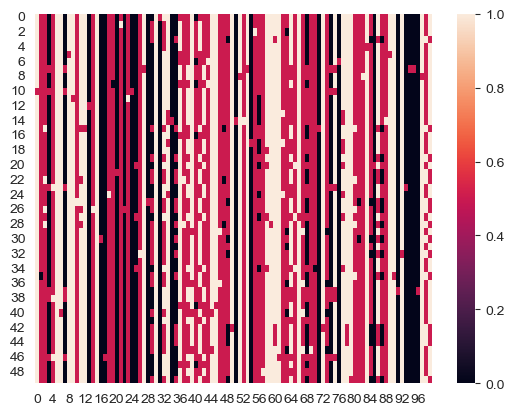

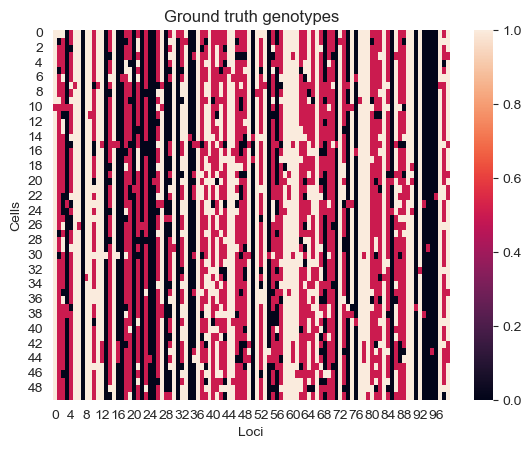

In [39]:
base_path = r'D:/PhD/SCITERNA/simulated_data/50c500m_param_testing/CNV_fraction_0_8'

mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))

genotype_pred_path = os.path.join(base_path, "sciterna", "sciterna_genotype", f"sciterna_genotype_0r0.txt")
genotype_path = os.path.join(base_path, "genotype", f"genotype_0.txt")

genotype_pred = np.loadtxt(genotype_pred_path, dtype=str)
genotype_gt = np.loadtxt(genotype_path, dtype=str)
genotype_gt = vectorized_map(genotype_gt)
genotype_pred = vectorized_map(genotype_pred)

sns.heatmap(genotype_pred[:,:100])
plt.show()
sns.heatmap(genotype_gt[:,:100])
plt.title("Ground truth genotypes")
plt.xlabel("Loci")
plt.ylabel("Cells")
plt.show()


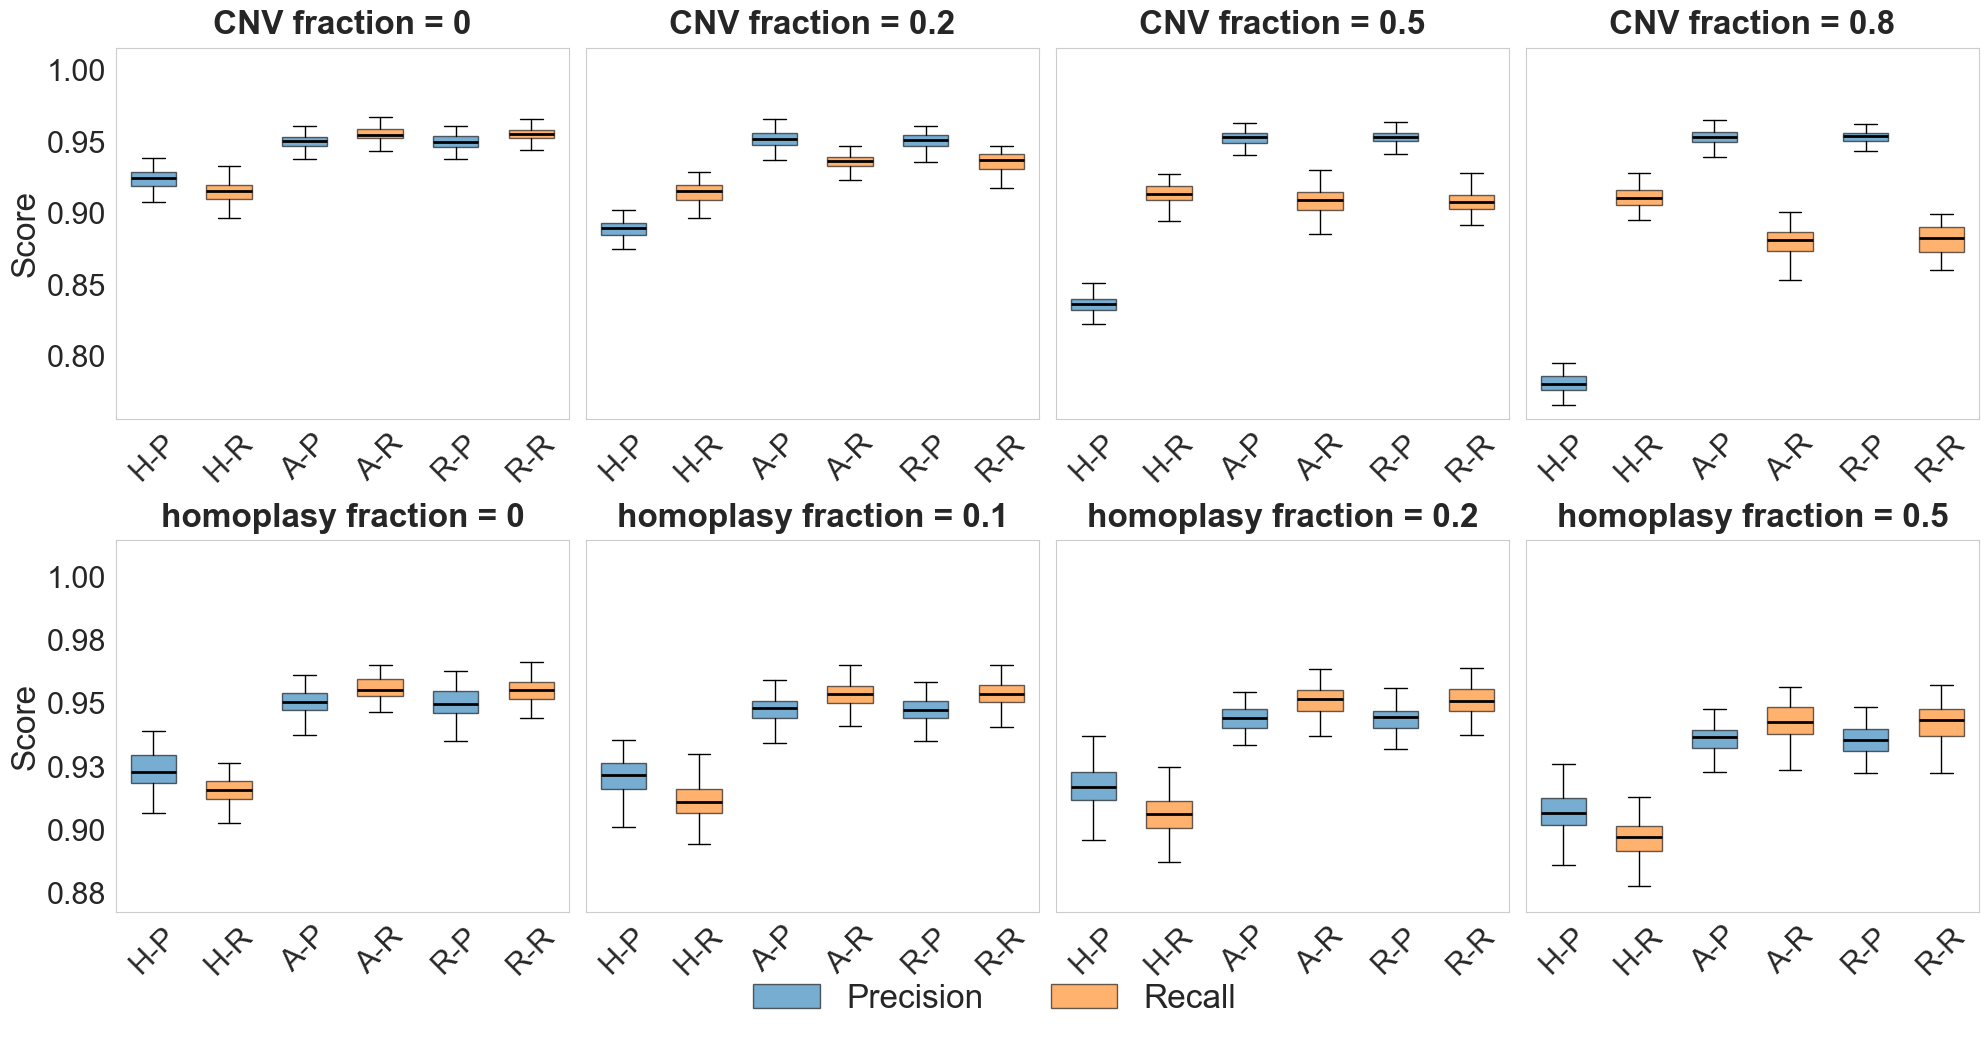

In [27]:
import matplotlib.ticker as mticker

alpha_value = 0.6
title_size = 24
label_size = 24
tick_size = 22
box_width = 2
boxplot_widths = 0.6

rows = 2
cols = max(len(v) for v in param_sets.values())

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 10), sharey="row")

parameters = list(param_sets.keys())

for row_idx, parameter in enumerate(parameters):
    row_whiskers = []
    param_values = param_sets[parameter]

    for col_idx, param_value in enumerate(param_values):
        param_str = f"{parameter}_{str(param_value).replace('.', '_')}"
        ax = axes[row_idx, col_idx]

        # Collect data: precision and recall per genotype
        data = []
        labels = []

        for genotype in genotype_classes:
            data.append(metrics[param_str][genotype]["precision"])
            data.append(metrics[param_str][genotype]["recall"])
            labels.extend([f"{genotype}-P", f"{genotype}-R"])

        box = ax.boxplot(
            data,
            widths=boxplot_widths,
            patch_artist=True,
            showfliers=False
        )

        # Coloring
        for i, patch in enumerate(box["boxes"]):
            patch.set_alpha(alpha_value)
            patch.set_facecolor("tab:blue" if i % 2 == 0 else "tab:orange")

        for line in box["medians"]:
            line.set_linewidth(box_width)
            line.set_color("black")

        whisker_data = np.concatenate([line.get_ydata() for line in box["whiskers"]])
        row_whiskers.append(whisker_data)

        ax.set_title(
            f"{parameter.replace('_', ' ')} = {param_value}",
            fontsize=title_size,
            fontweight="bold",
            pad=10
        )

        ax.set_xticks(range(1, len(labels) + 1))
        ax.set_xticklabels(labels, rotation=45, fontsize=tick_size)

        if col_idx == 0:
            ax.set_ylabel("Score", fontsize=label_size)

        ax.tick_params(axis="y", labelsize=tick_size)
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))
        ax.grid(False)

    # Uniform y-scale per row
    combined = np.concatenate(row_whiskers)
    ymin, ymax = np.nanmin(combined)-0.01, np.nanmax(combined) * 1.05

    for col_idx in range(len(param_values)):
        axes[row_idx, col_idx].set_ylim(ymin, ymax)


legend_elements = [
    Patch(facecolor="tab:blue",  edgecolor="black", alpha=alpha_value, label="Precision"),
    Patch(facecolor="tab:orange", edgecolor="black", alpha=alpha_value, label="Recall"),
]

fig.legend(
    handles=legend_elements,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=2,
    fontsize=label_size,
    frameon=False
)
plt.tight_layout()
plt.show()

In [4]:
param_sets = {
    'dropout': [0, 0.2, 0.4, 0.6],
    'overdispersion_Het': [3, 6, 10, 100],
    'overdispersion_Hom': [3, 6, 10, 100],
    'error_rate': [0.001, 0.01, 0.05, 0.1],
    'coverage_mean': [10, 30, 60, 100],
    'coverage_zero_inflation': [0, 0.2, 0.4, 0.6],
    'coverage_dispersion': [1, 2, 5, 10],
    "CNV_fraction": [0, 0.2, 0.5, 0.8],
    "homoplasy_fraction": [0, 0.1, 0.2, 0.5]
}
global_params = {}

if not use_summary_statistics:
    for param_name, param_values in param_sets.items():
        for param_value in param_values:
            param_str = f"{param_name}_{param_value}".replace('.', '_')
            base_path = os.path.join(path, f"{n_c}c{n_m}m_param_testing/{param_str}")
            print(param_str)

            vaf_differences = []
            path_len_distances = []
            rf_distances = []

            global_parameters = []

            for t in range(n_tests):
                genotype_pred_path = os.path.join(base_path, "sciterna", "sciterna_genotype", f"sciterna_genotype_{round}r{t}.txt")
                genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")
                params_path = os.path.join(base_path, "sciterna", "sciterna_global_parameters", f"sciterna_global_parameters_{round}r{t}.txt")
                global_p = np.loadtxt(params_path, dtype=float)
                global_parameters.append(global_p)
                genotype_pred = np.loadtxt(genotype_pred_path, dtype=str)
                genotype_gt = np.loadtxt(genotype_path, dtype=str)

                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                sciterna_parent_vec = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_parent_vec", f"sciterna_parent_vec_{round}r{t}.txt"), dtype=int)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_predicted = vectorized_map(genotype_pred)
                genotype_gt = vectorized_map(genotype_gt)
                unique_genotypes = np.unique(genotype_gt, axis=0)

                difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                vaf_differences.append(difference)

                ct_gt = CellTree(n_c)
                ct_sciterna = CellTree(n_c, flipped_mutation_direction=True)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_sciterna.use_parent_vec(sciterna_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))

                newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
                newick2 = to_newick(ct_sciterna, ct_sciterna.main_root) + ";"
                taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
                tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
                tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)
                rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))

            path_len_differences["SCITE-RNA"][param_str] = path_len_distances
            genotype_differences["SCITE-RNA"][param_str] = vaf_differences
            rf_differences["SCITE-RNA"][param_str] = rf_distances
            global_params[param_str] = global_parameters

            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
            print(np.nanmean(rf_distances), " mean Robinson-Foulds distance")

dropout_0


KeyboardInterrupt: 

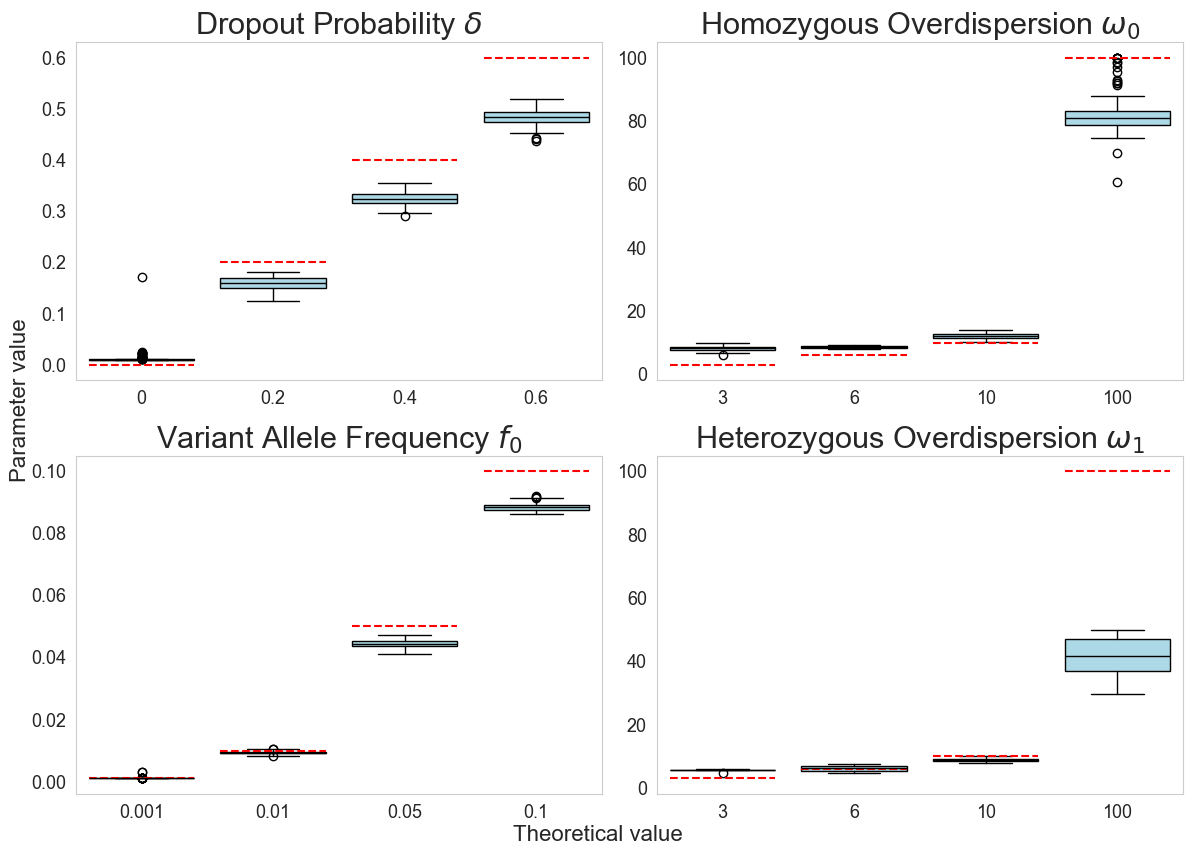

In [8]:
param_names = ["dropout", "overdispersion_Hom", "error_rate", "overdispersion_Het"]
titles = [r"Dropout Probability $\delta$", r"Homozygous Overdispersion $\omega_\mathrm{0}$", r"Variant Allele Frequency $f_\mathrm{0}$", r"Heterozygous Overdispersion $\omega_\mathrm{1}$"]

fig, axes = plt.subplots(2, 2, figsize=(12, 9))

axes = axes.ravel()

for i, param_name in enumerate(param_names):
    if param_name not in param_sets:
        continue

    ax = axes[i]
    all_estimates = []
    all_theoretical = []
    labels = []

    # Collect estimates for each parameter value
    for val in param_sets[param_name]:
        val_str = str(val).replace('.', '_')
        param_str_base = f"{param_name}_{val_str}"
        estimates_for_val = []
        arrs = global_params[param_str_base]

        if param_name == 'dropout':
            idx = 0
        elif param_name == 'overdispersion_Hom':
            idx = 1
        elif param_name == 'error_rate':
            idx = 2
        elif param_name == 'overdispersion_Het':
            idx = 3
        else:
            continue

        for arr in arrs:
            estimates_for_val.append(arr[idx])

        all_estimates.append(estimates_for_val)
        theoretical_val = float(str(val).replace('_', '.'))
        all_theoretical.append(theoretical_val)
        labels.append(str(val))

    # Plot boxplot
    bp = ax.boxplot(all_estimates, positions=range(len(labels)), patch_artist=True, widths=0.8)
    for box in bp['boxes']:
        box.set_facecolor("lightblue")
    for median in bp['medians']:
        median.set_color('black')

    # Plot horizontal lines for theoretical values
    for j, theo in enumerate(all_theoretical):
        ax.plot([j-0.4, j+0.4], [theo, theo], color='red', linestyle='--', linewidth=1.5)

    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_title(f"{titles[i]}", fontsize=22)
    ax.tick_params(axis='both', labelsize=13)

    ax.grid(False)

fig.text(0.01, 0.5, "Parameter value", va='center', rotation='vertical', fontsize=16)
fig.text(0.5, 0.01, "Theoretical value", ha='center', fontsize=16)
plt.subplots_adjust(hspace=0.5)
plt.tight_layout(rect=[0.015, 0.015, 1, 0.95])
plt.savefig(r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\results\figures\Parameter_inference.pdf")
plt.show()

In [6]:
if not use_summary_statistics:
    for param_name, param_values in param_sets.items():
        for param_value in param_values:
            param_str = f"{param_name}_{param_value}".replace('.', '_')
            base_path = os.path.join(path, f"{n_c}c{n_m}m_param_testing/{param_str}")
            print(param_str)

            vaf_differences = []
            path_len_distances = []
            rf_distances = []

            for t in range(n_tests):
                genotype_gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T

                if genotype_gt.ndim == 1:
                    genotype_gt = genotype_gt[:, np.newaxis]

                _, clones_gt = np.unique(genotype_gt, axis=1, return_inverse=True)

                clones_pred_path = os.path.join(base_path, "dendro", "dendro_clones", f"dendro_clones_{t}.txt")
                clones_pred = np.loadtxt(clones_pred_path, dtype=float)
                if len(clones_pred) != n_c:
                    print("Cells were filtered out, skipping this test")
                    continue

                ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
                alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)

                dendro_parent_vec = np.loadtxt(os.path.join(base_path, "dendro", "dendro_parent_vec", f"dendro_parent_vec_{t}.txt"), dtype=int)

                alt = np.loadtxt(alt_path)
                ref = np.loadtxt(ref_path)
                alt_t = alt.T
                ref_t = ref.T

                with np.errstate(invalid='ignore'):
                    vaf_observed = alt_t/(alt_t + ref_t)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(genotype_gt)

                unique_classes = np.unique(clones_pred)

                # For each unique class, replace column values with the mean of the columns of that class
                for cls in unique_classes:
                    class_indices = np.where(clones_pred == cls)[0]
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=RuntimeWarning)
                        mean_values = np.nanmean(vaf_observed[:, class_indices], axis=1)

                    # in case the mean is nan replace it with the mean genotype over all cells
                    row_nanmean = np.nanmean(vaf_observed, axis=1)
                    if np.isnan(row_nanmean).any():
                        raise ValueError("Error: The array contains NaN values.")
                    mean_values = np.where(np.isnan(mean_values), row_nanmean, mean_values)
                    if np.isnan(mean_values).any():
                        raise ValueError("Error: The array contains NaN values.")

                    vaf_observed[:, class_indices] = np.tile(mean_values[:, np.newaxis], len(class_indices))


                genotype_predicted = np.round(vaf_observed * 2) / 2
                if np.isnan(genotype_predicted).any():
                    print("Error: The array contains NaN values.")

                vaf_difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                vaf_differences.append(vaf_difference)

                ct_gt = CellTree(n_c)
                ct_dendro = CellTree(n_c)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_dendro.use_parent_vec(dendro_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_dendro))

                newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
                newick2 = to_newick(ct_dendro, ct_dendro.main_root) + ";"
                taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
                tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
                tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)
                rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))

            path_len_differences["DENDRO"][param_str] = path_len_distances
            genotype_differences["DENDRO"][param_str] = vaf_differences
            rf_differences["DENDRO"][param_str] = rf_distances

            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
            print(np.nanmean(rf_distances), " mean Robinson-Foulds distance")

dropout_0


KeyboardInterrupt: 

In [20]:
if not use_summary_statistics:
    for param_name, param_values in param_sets.items():
        for param_value in param_values:
            param_str = f"{param_name}_{param_value}".replace('.', '_')
            base_path = os.path.join(path, f"{n_c}c{n_m}m_param_testing/{param_str}")
            print(param_str)

            vaf_differences = []
            path_len_distances = []
            rf_distances = []

            for t in range(n_tests):
                genotype_gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T
                vaf_predicted = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_vaf", f"sclineager_vaf_{t}.txt"), dtype=float).T

                if genotype_gt.ndim == 1:
                    genotype_gt = genotype_gt[:, np.newaxis]

                _, clones_gt = np.unique(genotype_gt, axis=1, return_inverse=True)

                clones_pred_path = os.path.join(base_path, "sclineager", "sclineager_clones", f"sclineager_clones_{t}.txt")
                clones_pred = np.loadtxt(clones_pred_path, dtype=float)

                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
                sclineager_parent_vec = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_parent_vec", f"sclineager_parent_vec_{t}.txt"), dtype=int)
                sclineager_selected = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_selected", f"sclineager_selected_{t}.txt"), dtype=int).astype(bool)

                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(genotype_gt)

                genotype_predicted = np.round(vaf_predicted * 2) / 2
                if genotype_predicted.shape != genotype_gt.shape:

                    print(f"Cells or mutations were filtered out. {np.sum(sclineager_selected == 0)} mutations filtered out.")
                    genotype_gt = genotype_gt[sclineager_selected]

                    if genotype_gt.shape != genotype_predicted.shape:
                        print("Cells filtered out. Continue.")
                        continue

                vaf_difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                vaf_differences.append(vaf_difference)

                ct_gt = CellTree(n_c)
                ct_sclineager = CellTree(n_c)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_sclineager.use_parent_vec(sclineager_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_sclineager))

                newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
                newick2 = to_newick(ct_sclineager, ct_sclineager.main_root) + ";"
                taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
                tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
                tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)
                rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))

            path_len_differences["SClineager"][param_str] = path_len_distances
            genotype_differences["SClineager"][param_str] = vaf_differences
            rf_differences["SClineager"][param_str] = rf_distances

            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
            print(np.nanmean(rf_distances), " mean Robinson-Foulds distance")

dropout_0
Cells or mutations were filtered out. 1 mutations filtered out.
Cells or mutations were filtered out. 1 mutations filtered out.
4.7592  mean path length distance
0.05562051503006012  mean abs difference of vafs predicted
92.68  mean Robinson-Foulds distance
dropout_0_2
Cells or mutations were filtered out. 1 mutations filtered out.
Cells or mutations were filtered out. 2 mutations filtered out.
Cells or mutations were filtered out. 1 mutations filtered out.
4.774930612244899  mean path length distance
0.0688543196481316  mean abs difference of vafs predicted
92.82  mean Robinson-Foulds distance
dropout_0_4
Cells or mutations were filtered out. 1 mutations filtered out.
4.861885714285714  mean path length distance
0.08275138316633267  mean abs difference of vafs predicted
92.74  mean Robinson-Foulds distance
dropout_0_6
Cells or mutations were filtered out. 1 mutations filtered out.
Cells or mutations were filtered out. 1 mutations filtered out.
Cells or mutations were filtere

In [22]:
if not use_summary_statistics:
    for param_name, param_values in param_sets.items():
        for param_value in param_values:
            param_str = f"{param_name}_{param_value}".replace('.', '_')
            base_path = os.path.join(path, f"{n_c}c{n_m}m_param_testing/{param_str}")
            print(param_str)

            vaf_differences = []
            path_len_distances = []
            rf_distances = []

            for t in range(n_tests):
                genotype_gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T

                if not os.path.exists(os.path.join(base_path, "phylinsic", "phylinsic_parent_vec", f"phylinsic_parent_vec_{t}.txt")) or not os.path.exists(os.path.join(base_path, "phylinsic", "phylinsic_genotype", f"phylinsic_genotype_{t}.txt")):
                    print("PhylinSic parent vector file not found, skipping this test")
                    continue
                genotype_predicted = np.loadtxt(os.path.join(base_path, "phylinsic", "phylinsic_genotype", f"phylinsic_genotype_{t}.txt"), dtype=str)[1:]

                true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)

                phylinsic_parent_vec = np.loadtxt(os.path.join(base_path, "phylinsic", "phylinsic_parent_vec", f"phylinsic_parent_vec_{t}.txt"), dtype=int)


                mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
                vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
                genotype_gt = vectorized_map(genotype_gt)
                genotype_predicted = vectorized_map(genotype_predicted)

                if genotype_predicted.shape != genotype_gt.shape:
                    print("Cells or mutations were filtered out")
                    continue

                vaf_difference = np.mean(np.abs(genotype_predicted - genotype_gt))
                vaf_differences.append(vaf_difference)

                ct_gt = CellTree(n_c)
                ct_phylinsic = CellTree(n_c)

                ct_gt.use_parent_vec(true_parent_vec)
                ct_phylinsic.use_parent_vec(phylinsic_parent_vec)

                path_len_distances.append(path_len_dist(ct_gt, ct_phylinsic))

                newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
                newick2 = to_newick(ct_phylinsic, ct_phylinsic.main_root) + ";"
                taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
                tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
                tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)
                rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))


            path_len_differences["PhylinSic"][param_str] = path_len_distances
            genotype_differences["PhylinSic"][param_str] = vaf_differences
            rf_differences["PhylinSic"][param_str] = rf_distances

            print(np.mean(path_len_distances), " mean path length distance")
            print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
            print(np.nanmean(rf_distances), " mean Robinson-Foulds distance")

dropout_0
3.7758122448979594  mean path length distance
0.0744018  mean abs difference of vafs predicted
89.48  mean Robinson-Foulds distance
dropout_0_2
4.252914285714286  mean path length distance
0.09370540000000002  mean abs difference of vafs predicted
91.26  mean Robinson-Foulds distance
dropout_0_4
4.623967346938776  mean path length distance
0.11876439999999999  mean abs difference of vafs predicted
92.54  mean Robinson-Foulds distance
dropout_0_6
4.635314285714285  mean path length distance
0.14538839999999997  mean abs difference of vafs predicted
92.78  mean Robinson-Foulds distance
overdispersion_Het_3
4.530130612244898  mean path length distance
0.11275840000000001  mean abs difference of vafs predicted
91.96  mean Robinson-Foulds distance
overdispersion_Het_6
4.334375510204081  mean path length distance
0.09402700000000001  mean abs difference of vafs predicted
91.12  mean Robinson-Foulds distance
overdispersion_Het_10
3.917763265306123  mean path length distance
0.083951

In [5]:
outdir = Path(r"D:\PhD\SCITERNA\simulated_data/json_outputs")
# outdir.mkdir(parents=True, exist_ok=True)

with open(outdir / "path_len_differences.json", "r") as f:
    path_len_differences = json.load(f)

with open(outdir / "genotype_differences.json", "r") as f:
    genotype_differences = json.load(f)

with open(outdir / "rf_differences.json", "r") as f:
    rf_differences = json.load(f)

# with open(outdir / "path_len_differences.json", "w") as f:
#     json.dump(path_len_differences, f, indent=2)
#
# with open(outdir / "genotype_differences.json", "w") as f:
#     json.dump(genotype_differences, f, indent=2)
#
# with open(outdir / "rf_differences.json", "w") as f:
#     json.dump(rf_differences, f, indent=2)

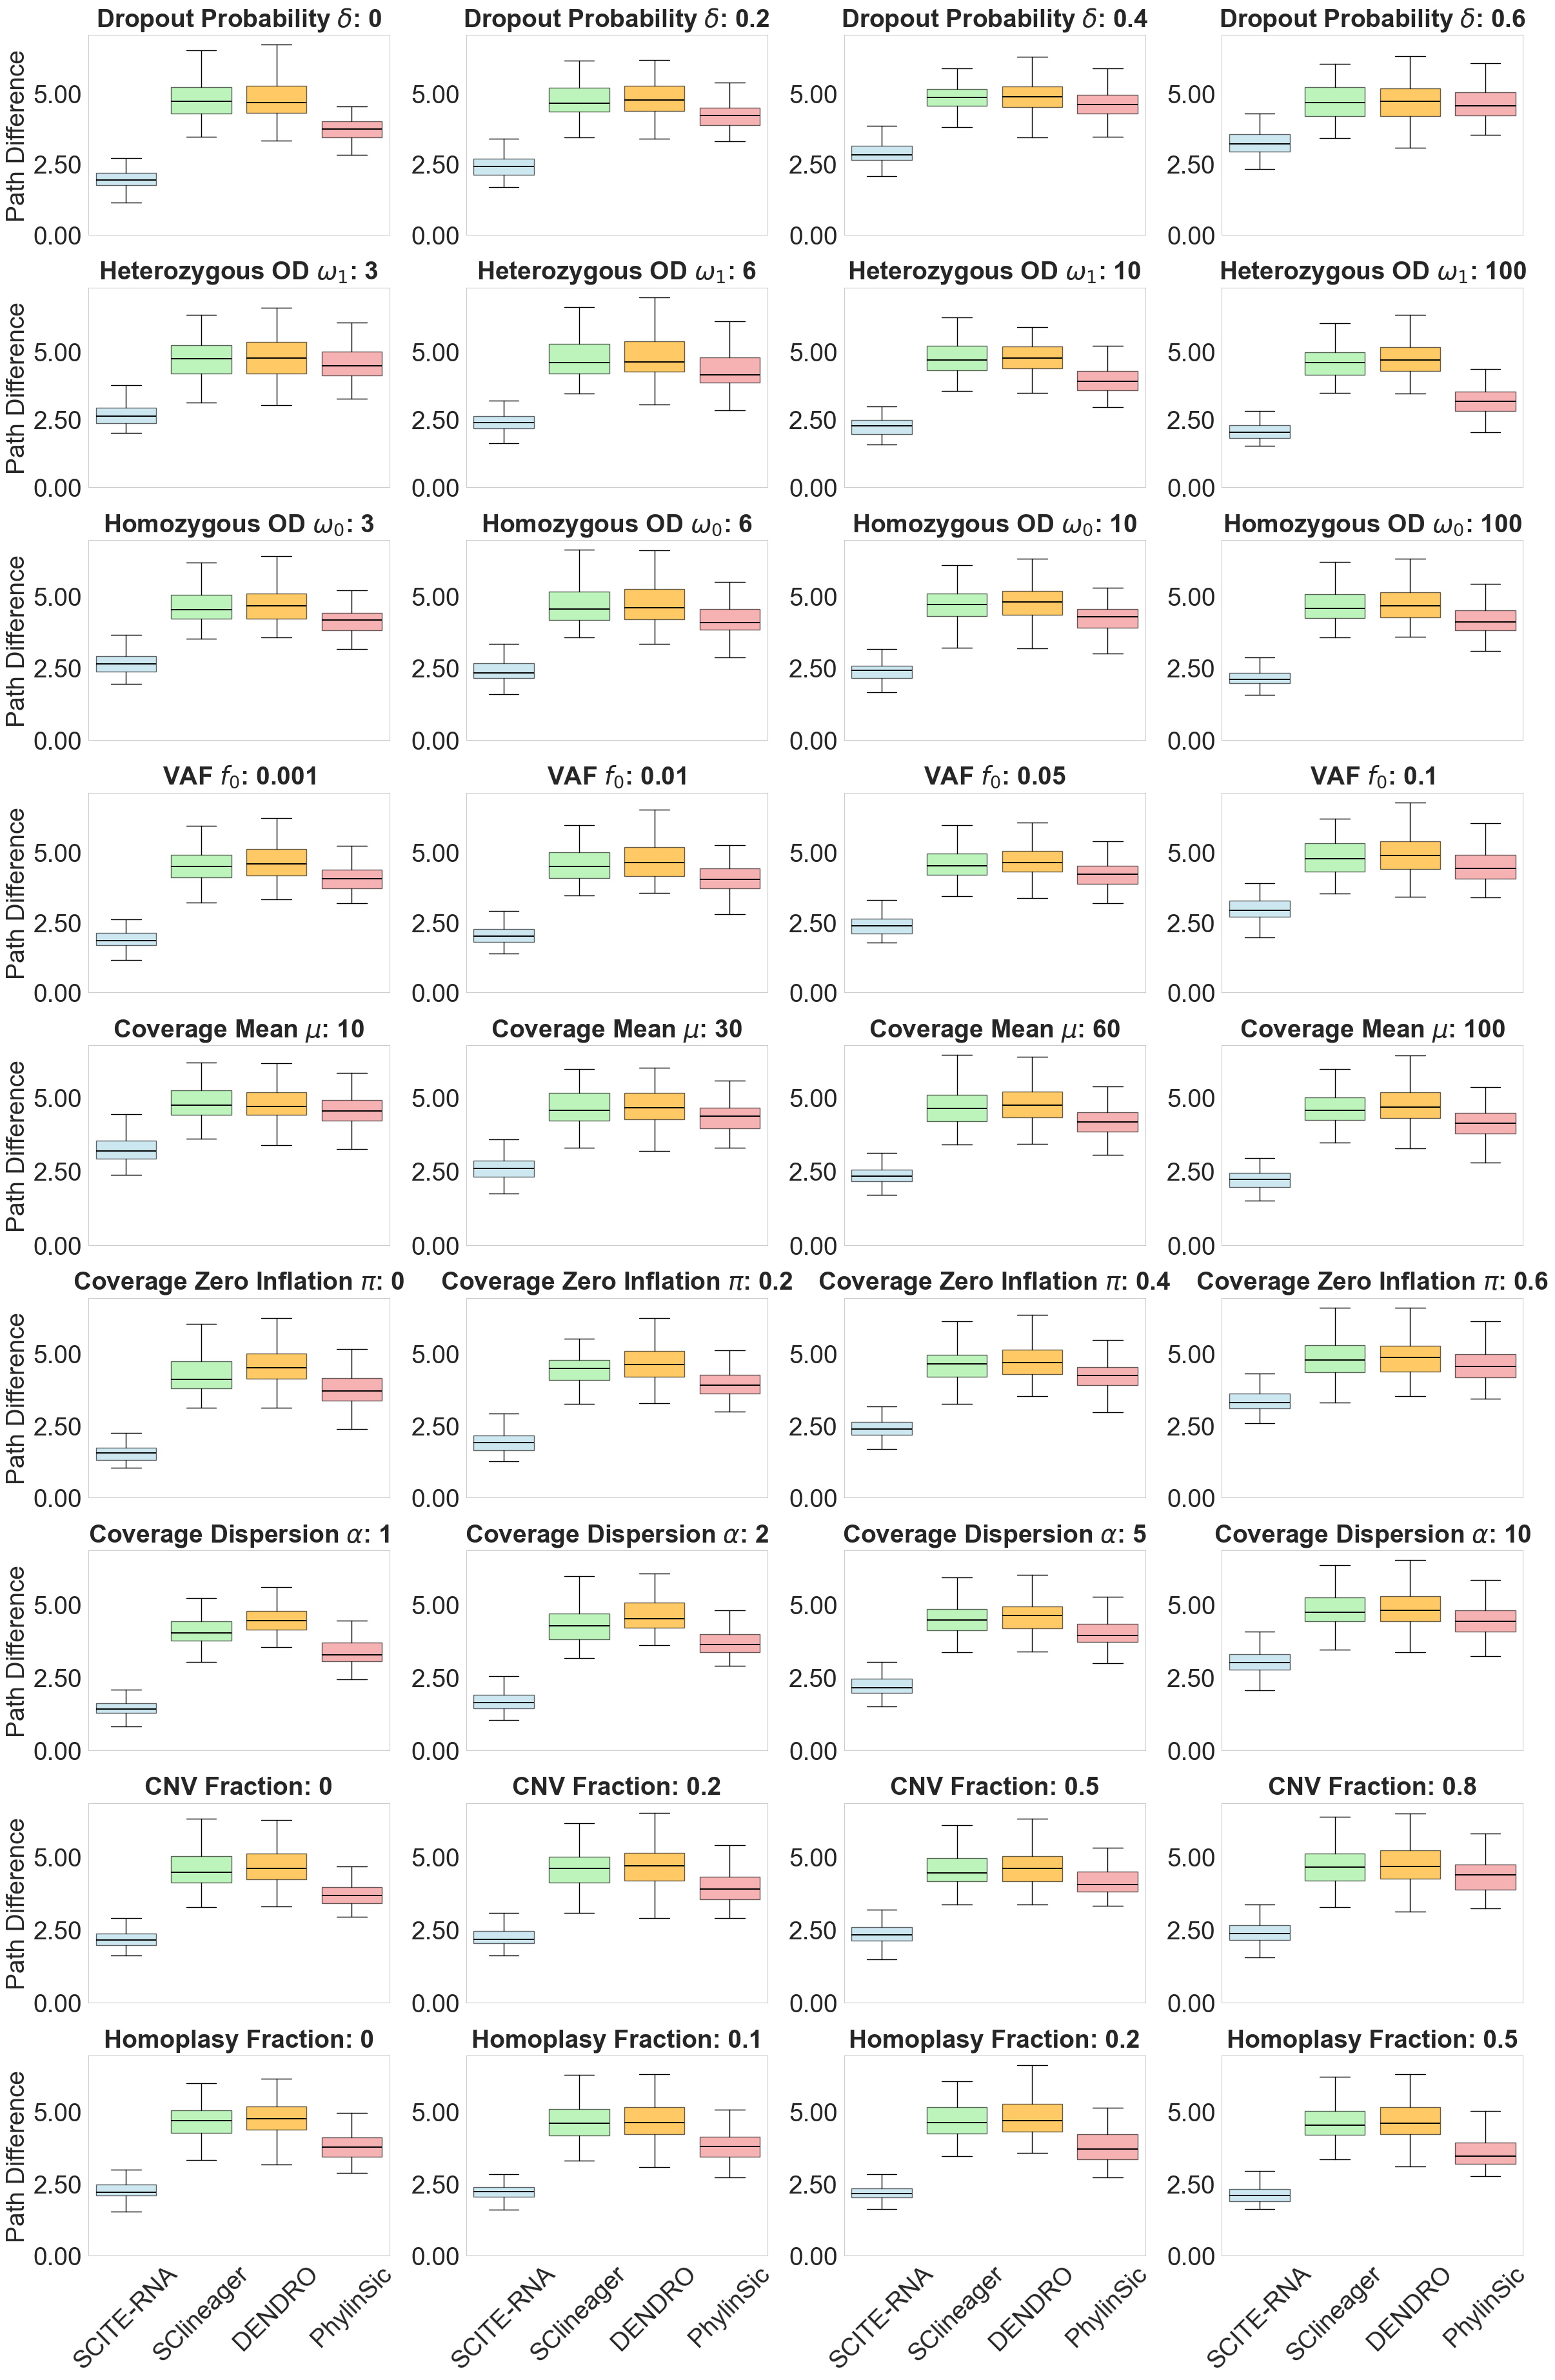

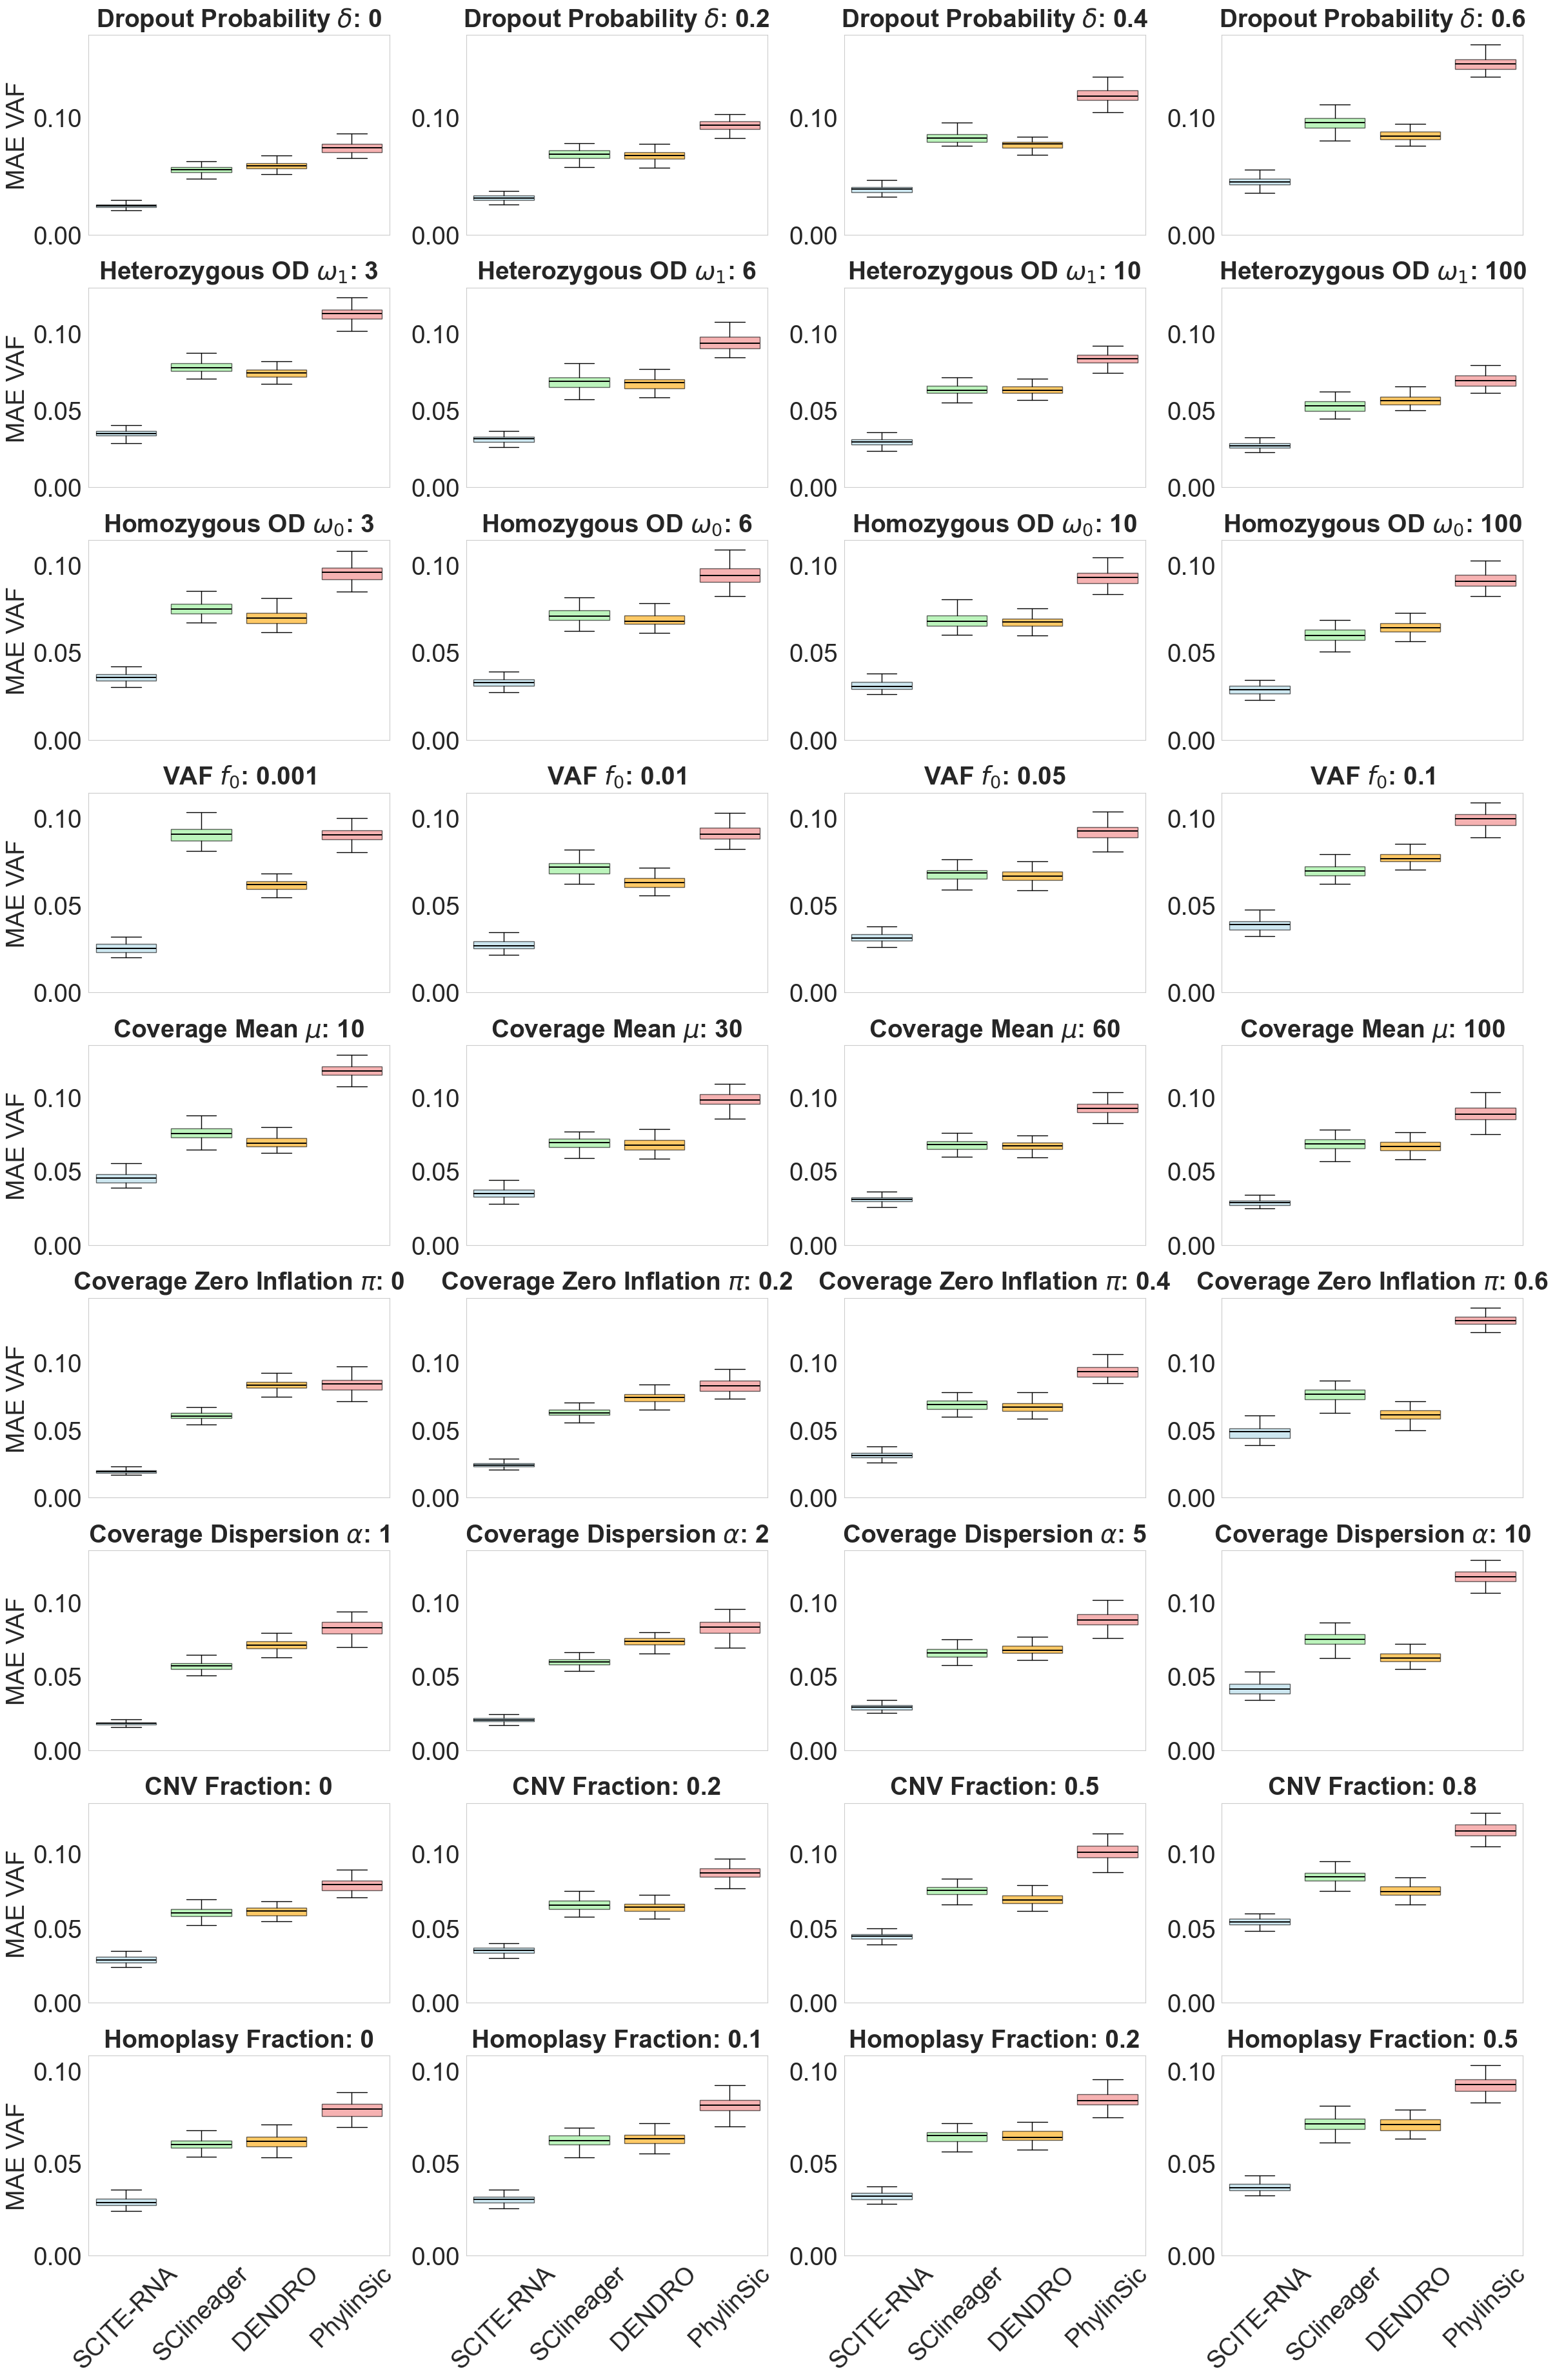

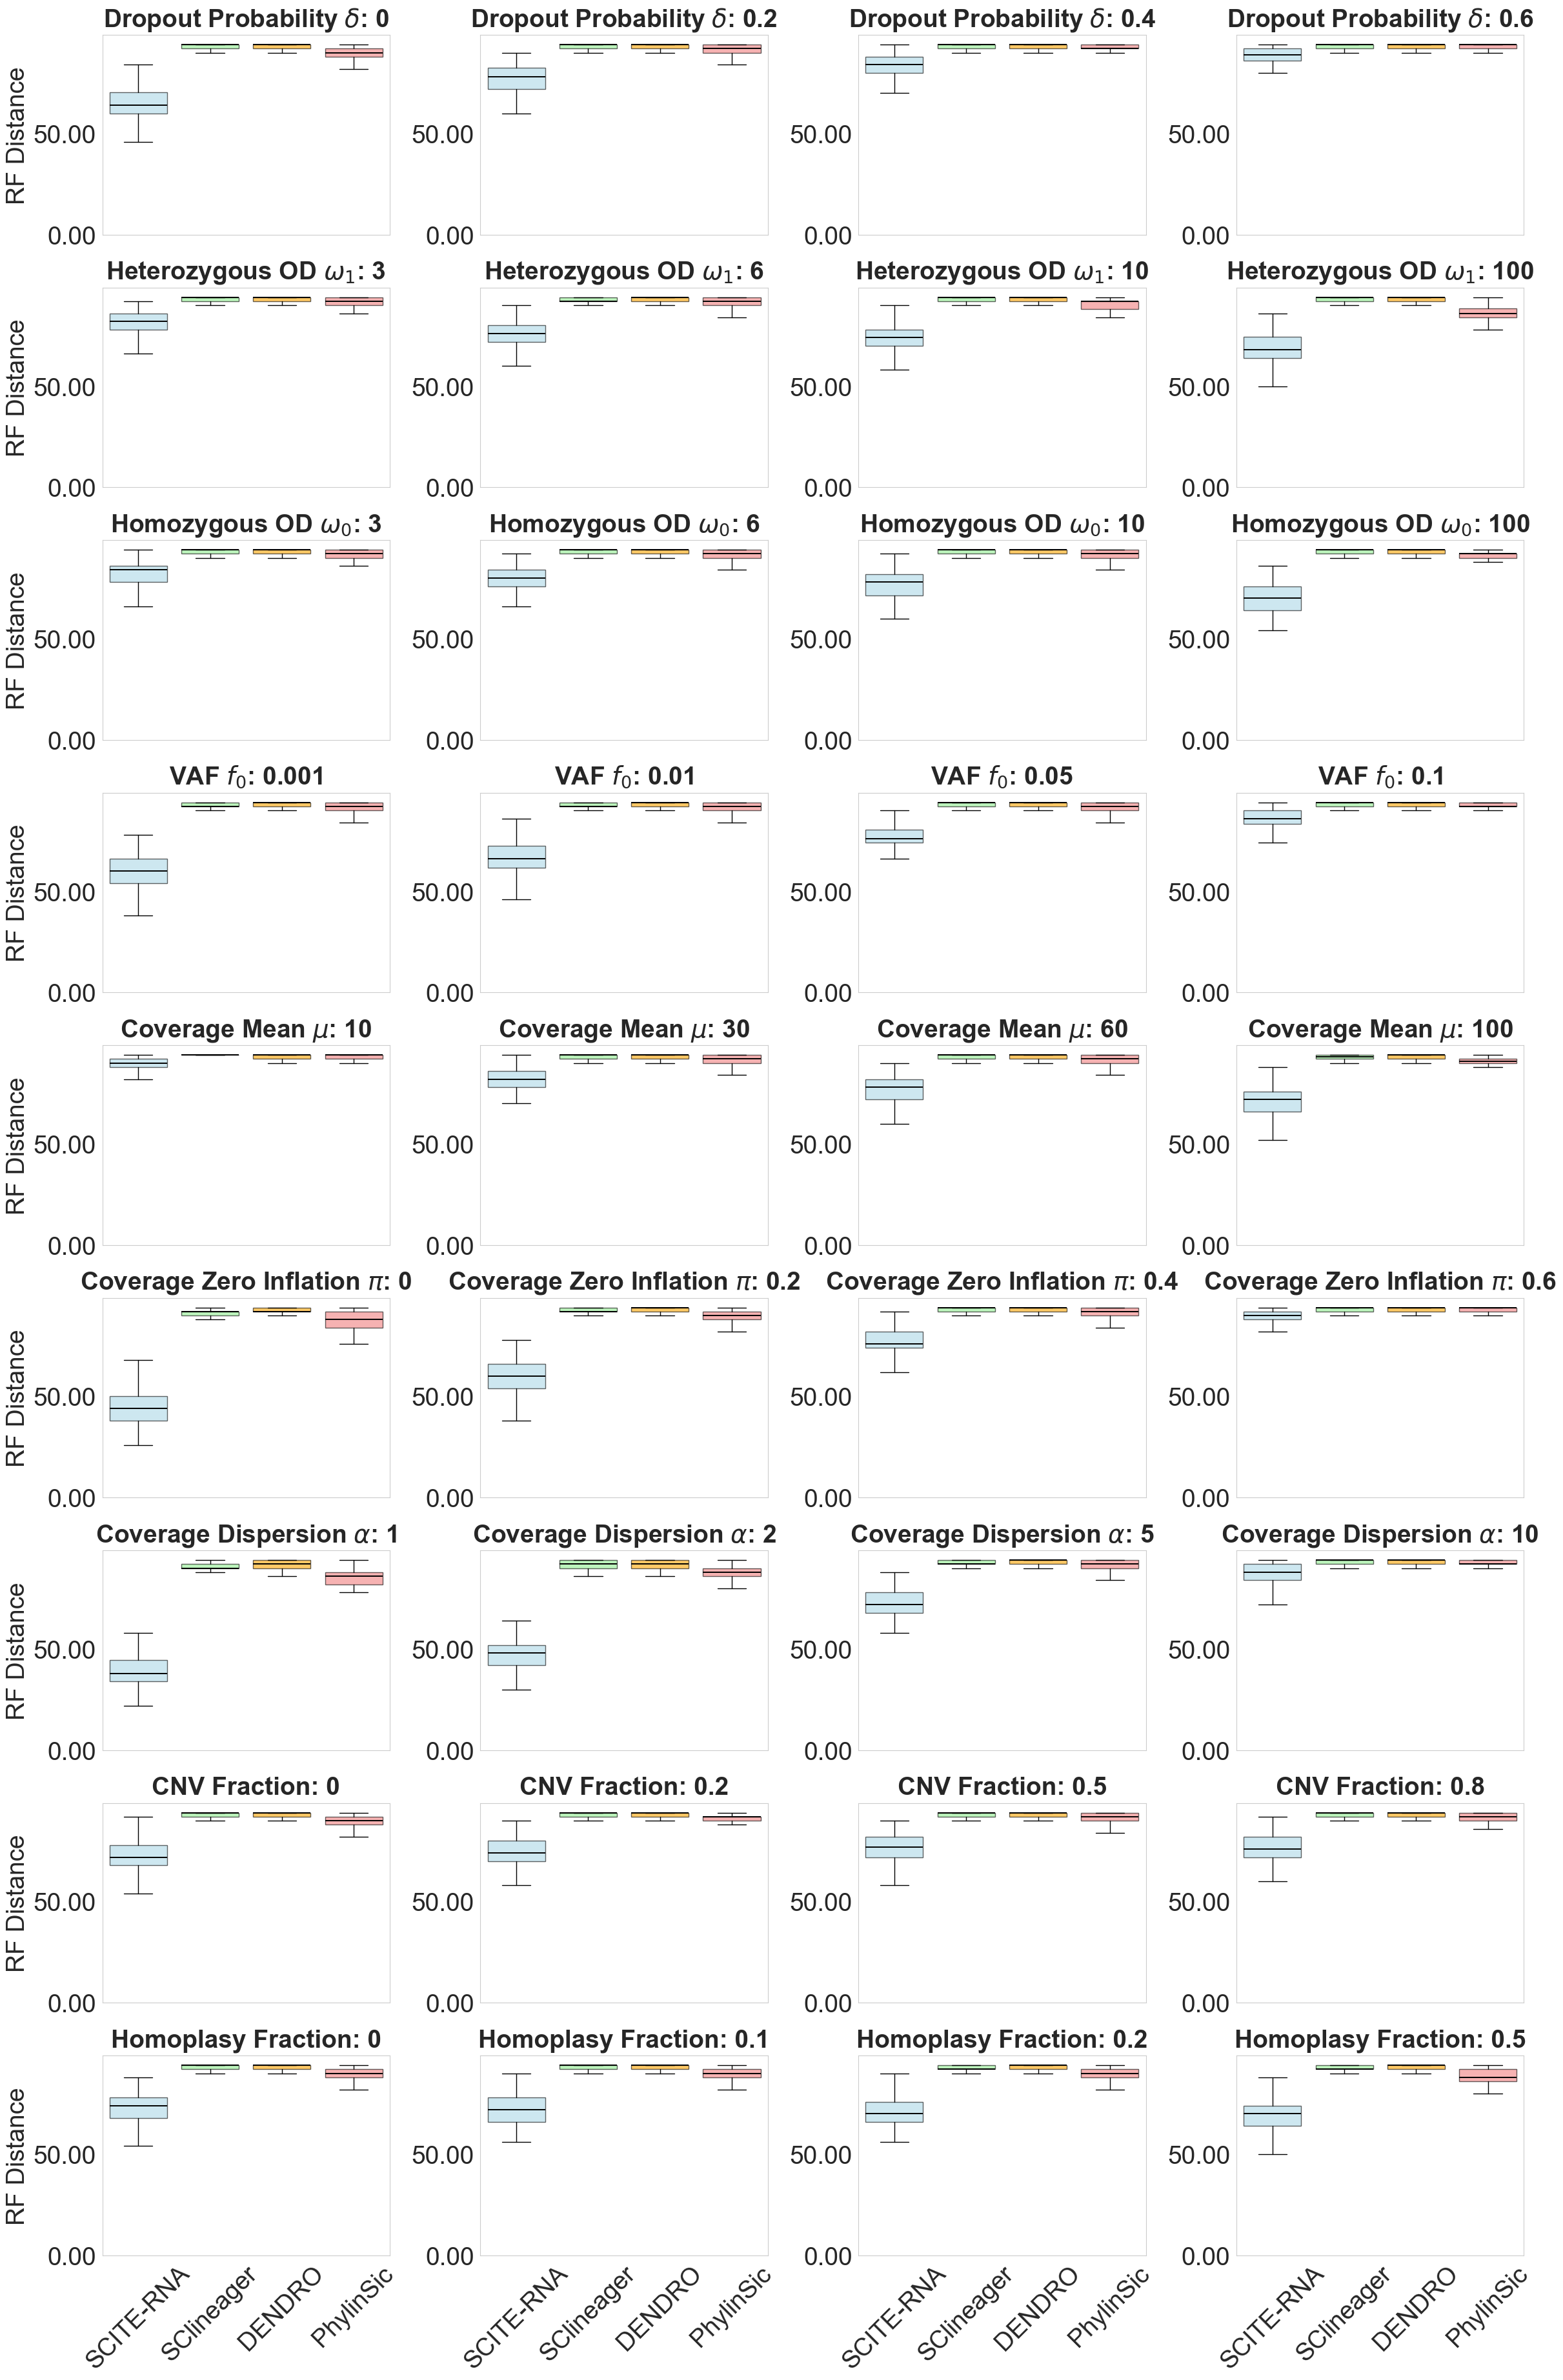

In [6]:
def plot_parameter_results(metric = "Path Difference", data={}, models=["SCITE-RNA", "DENDRO"]):

    rows = len(param_sets)
    cols = 4

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows + 1), sharey=False)
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)

    colors_dict = {"SCITE-RNA": "lightblue",
        "SClineager": "lightgreen",
        "DENDRO": "orange",
        "PhylinSic":  "lightcoral"
    }
    colors = [colors_dict[model] for model in models]

    param_to_name = {
        'dropout': r"Dropout Probability $\delta$",
        'overdispersion_Het': r"Heterozygous OD $\omega_\mathrm{1}$",
        'overdispersion_Hom': r"Homozygous OD $\omega_\mathrm{0}$",
        'error_rate': r"VAF $f_\mathrm{0}$",
        'coverage_mean': r"Coverage Mean $\mu$",
        'coverage_zero_inflation': r"Coverage Zero Inflation $\pi$",
        'coverage_dispersion': r"Coverage Dispersion $\alpha$",
        "CNV_fraction": "CNV Fraction",
        "homoplasy_fraction": "Homoplasy Fraction"
    }

    alpha_value = 0.6

    title_size = 28
    label_size = 28
    tick_size = 28
    box_width = 1.4
    boxplot_widths = 0.8

    parameters = param_sets.keys()

    for row_idx, parameter in enumerate(parameters):
        row_whiskers = []
        column_values = param_sets[parameter]

        for col_idx, param_value in enumerate(column_values):
            sample_key = f"{parameter}_{param_value}".replace('.', '_')
            all_samples = [data[model][sample_key] for model in models]

            if metric == "Robinson-Foulds Distance":
                all_samples = np.array(all_samples).T/(2*(n_c-3))

            ax = axes[row_idx, col_idx]
            box = ax.boxplot(all_samples, patch_artist=True, widths=boxplot_widths, showfliers=False)

            for patch, color in zip(box['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(alpha_value)

            for line in box['medians']:
                line.set_linewidth(box_width)
                line.set_color("black")

            whisker_data = np.concatenate([line.get_ydata() for line in box['whiskers']])
            row_whiskers.append(whisker_data)

            ax.set_title(f"{param_to_name[parameter]}: {param_value}", fontsize=title_size, pad=10, fontweight="bold")

            if row_idx == rows - 1:
                ax.set_xticklabels(models, fontsize=tick_size)
            else:
                ax.set_xticks([])

            if col_idx == 0:
                ax.set_ylabel(metric, fontsize=label_size)

            ax.tick_params(axis='x', labelsize=tick_size, rotation=45)
            ax.tick_params(axis='y', labelsize=tick_size)
            ax.grid(False)
            ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

        # Apply uniform y-limits across each row
        combined = np.concatenate(row_whiskers)
        ymin, ymax = np.nanmin(combined), np.nanmax(combined)
        # yrange = ymax - ymin
        ymin = 0
        ymax = ymax*1.05

        for col_idx in range(cols):
            axes[row_idx, col_idx].set_ylim(ymin, ymax)

    plt.tight_layout()

    # plt.savefig(f"../data/results/figures/Figure_Parameter_comparison_{metric}.pdf")
    plt.show()

plot_parameter_results("Path Difference", path_len_differences, models=["SCITE-RNA", "SClineager", "DENDRO","PhylinSic"])
plot_parameter_results("MAE VAF", genotype_differences, models=["SCITE-RNA", "SClineager", "DENDRO", "PhylinSic"])
plot_parameter_results("RF Distance", rf_differences, models=["SCITE-RNA", "SClineager", "DENDRO", "PhylinSic"])

In [51]:
n_rounds = 20
vafs = {}
plds = {}
rfs = {}

global_params = {}

if not use_summary_statistics:
    for r in range(n_rounds):
        base_path = os.path.join(path, f"{n_c}c{n_m}m")

        vaf_differences = []
        path_len_distances = []
        rf_distances = []
        g_params = []

        for t in range(n_tests):
            genotype_pred_path = os.path.join(base_path, "sciterna", "sciterna_genotype", f"sciterna_genotype_{r}r{t}.txt")
            genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")
            params_path = os.path.join(base_path, "sciterna", "sciterna_global_parameters", f"sciterna_global_parameters_{r}r{t}.txt")
            genotype_pred = np.loadtxt(genotype_pred_path, dtype=str)
            genotype_gt = np.loadtxt(genotype_path, dtype=str)
            global_p = np.loadtxt(params_path, dtype=float)
            g_params.append(global_p)

            true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
            sciterna_parent_vec = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_parent_vec", f"sciterna_parent_vec_{r}r{t}.txt"), dtype=int)

            mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
            vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
            genotype_predicted = vectorized_map(genotype_pred)
            genotype_gt = vectorized_map(genotype_gt)
            unique_genotypes = np.unique(genotype_gt, axis=0)

            difference = np.mean(np.abs(genotype_predicted - genotype_gt))
            vaf_differences.append(difference)

            ct_gt = CellTree(n_c)
            ct_sciterna = CellTree(n_c, flipped_mutation_direction=True)

            ct_gt.use_parent_vec(true_parent_vec)
            ct_sciterna.use_parent_vec(sciterna_parent_vec)

            path_len_distances.append(path_len_dist(ct_gt, ct_sciterna))

            newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
            newick2 = to_newick(ct_sciterna, ct_sciterna.main_root) + ";"
            taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
            tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
            tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)
            rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))

        plds[r] = path_len_distances
        vafs[r] = vaf_differences
        rfs[r] = rf_distances
        global_params[r] = g_params

        print(np.mean(path_len_distances), " mean path length distance")
        print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
        print(np.nanmean(rf_distances), " mean Robinson-Foulds distance")

2.4141795918367346  mean path length distance
0.03174459999999999  mean abs difference of vafs predicted
75.8  mean Robinson-Foulds distance
2.3880163265306122  mean path length distance
0.030648000000000005  mean abs difference of vafs predicted
75.68  mean Robinson-Foulds distance
2.4012000000000002  mean path length distance
0.030756799999999997  mean abs difference of vafs predicted
75.6  mean Robinson-Foulds distance
2.374873469387755  mean path length distance
0.0307578  mean abs difference of vafs predicted
75.56  mean Robinson-Foulds distance
2.386848979591837  mean path length distance
0.03065739999999999  mean abs difference of vafs predicted
75.58  mean Robinson-Foulds distance
2.384391836734694  mean path length distance
0.0308088  mean abs difference of vafs predicted
75.56  mean Robinson-Foulds distance
2.3769551020408164  mean path length distance
0.0305176  mean abs difference of vafs predicted
75.34  mean Robinson-Foulds distance
2.396840816326531  mean path length dis

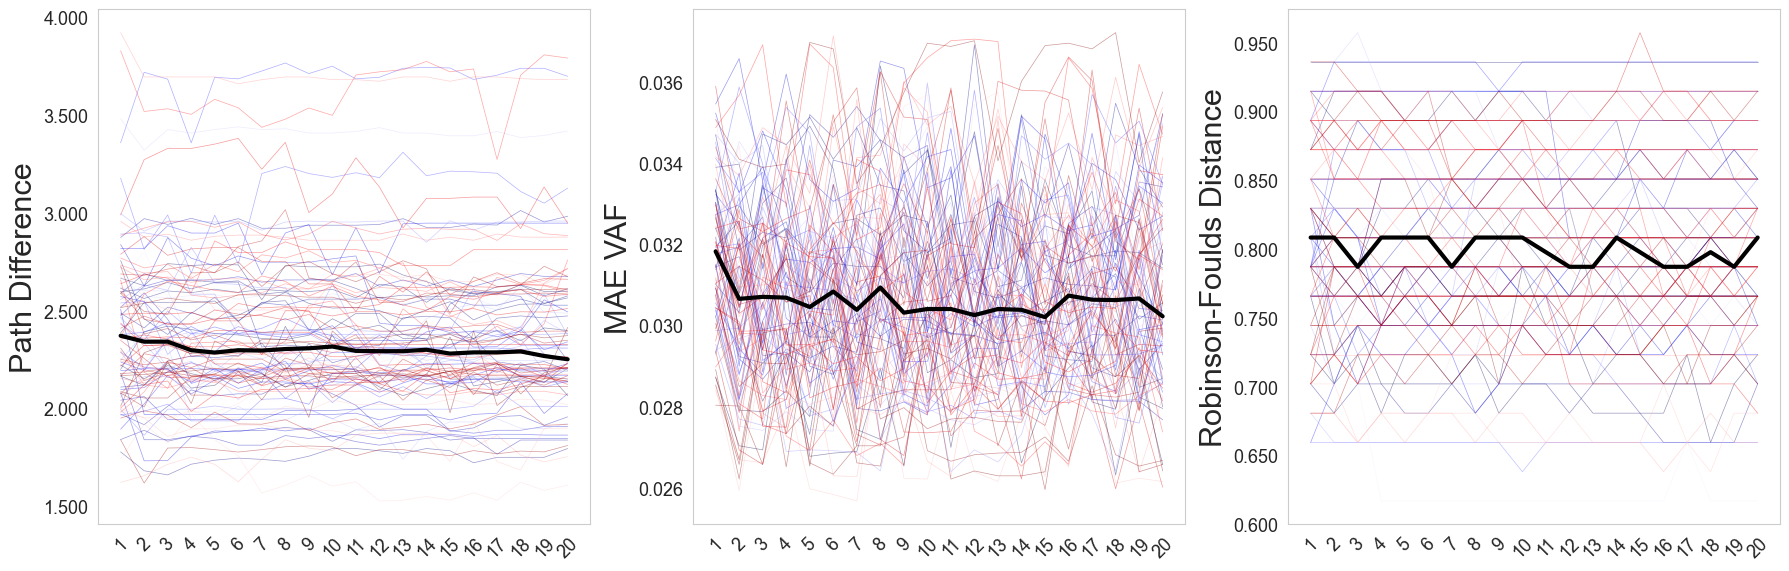

In [57]:
def plot_metrics_across_rounds(plds, vafs, rfs, n_rounds,
                               round_labels=None,
                               figsize=(18, 6),
                               tick_font=13,
                               ylabel_font=22):
    def build_list(metric_dict):
        all_data = []
        present_rounds = []
        for r in range(n_rounds):
            vals = metric_dict.get(r, None)
            if vals is None:
                all_data.append([])
            else:
                arr = np.asarray(vals, dtype=float)
                arr = arr[~np.isnan(arr)]
                all_data.append(arr if arr.size > 0 else [])
            present_rounds.append(r)
        return all_data

    data_pld = build_list(plds)
    data_vaf = build_list(vafs)
    data_rf  = build_list(rfs)

    if round_labels is None:
        round_labels = [str(r+1) for r in range(n_rounds)]

    fig, axes = plt.subplots(1, 3, figsize=figsize)
    panel_info = [
        (data_pld, "Path Difference"),
        (data_vaf, "MAE VAF"),
        (data_rf,  "Robinson-Foulds Distance")
    ]

    cmap = plt.get_cmap("seismic")
    colors = [cmap(i) for i in np.linspace(0, 1, n_tests)]

    for ax, (data, title) in zip(axes, panel_info):
        prepared = [d if (isinstance(d, np.ndarray) and d.size>0) or (isinstance(d, list) and len(d)>0) else np.array([np.nan]) for d in data]

        if title == "Robinson-Foulds Distance":
            prepared = np.array(prepared)/(2*(n_c-3))

        for i in range(n_tests):
            ax.plot(np.array(prepared)[:,i], color = colors[i], alpha=0.4, linewidth=0.5)

        ax.plot(np.median(prepared, axis=1), color = "black", linewidth=3)

        ax.set_xticks(np.arange(len(prepared)))
        ax.set_xticklabels(round_labels, rotation=45, fontsize=tick_font)
        ax.tick_params(axis='y', labelsize=tick_font)
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.3f'))
        ax.grid(False)
        ax.set_ylabel(title, fontsize=ylabel_font)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    # plt.savefig(r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\results\figures\Rounds.pdf")
    plt.show()

plot_metrics_across_rounds(plds, vafs, rfs, n_rounds)

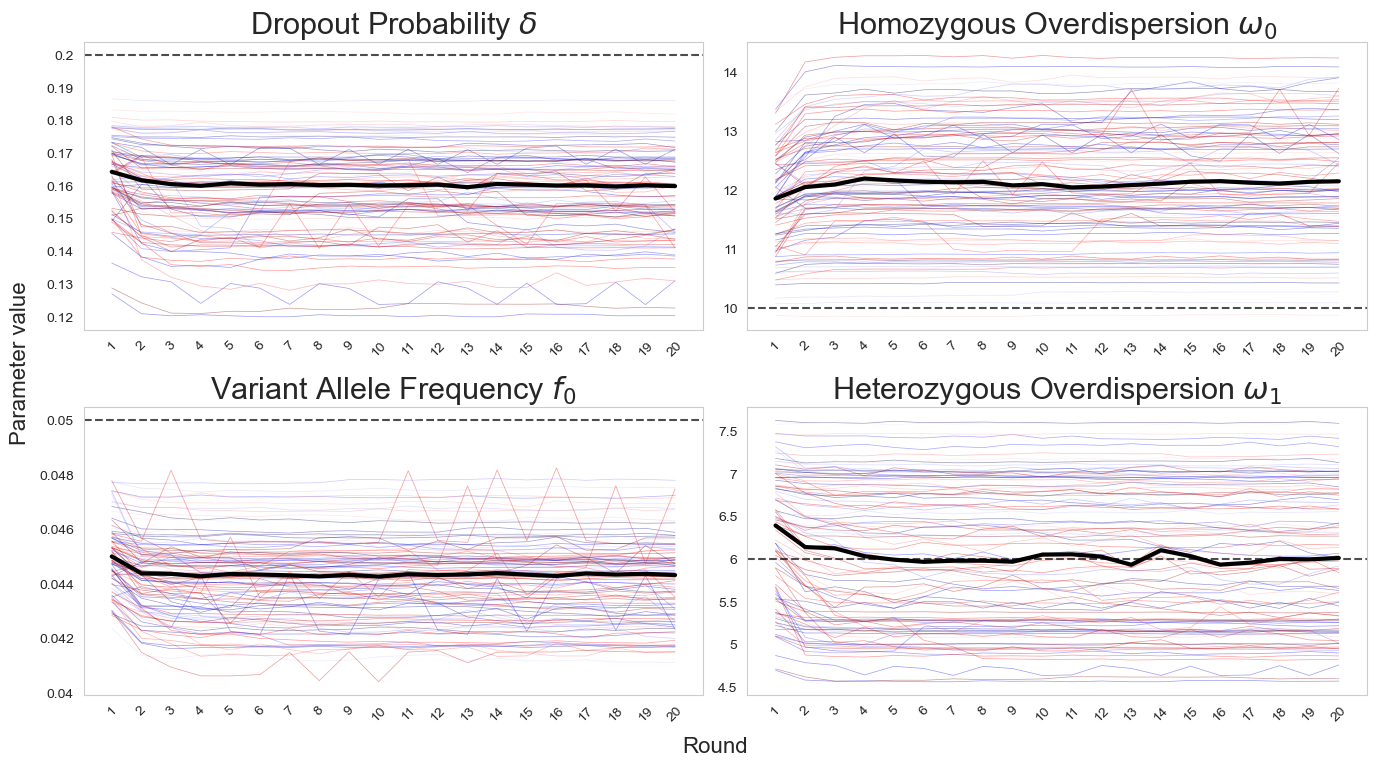

In [56]:
def plot_global_params_across_rounds(global_params, n_rounds,
                                     figsize=(14, 8),
                                     title_font=22,
                                     tick_font=10,
                                     ylabel_font=16):

    param_names = [r"Dropout Probability $\delta$", r"Homozygous Overdispersion $\omega_\mathrm{0}$", r"Variant Allele Frequency $f_\mathrm{0}$", r"Heterozygous Overdispersion $\omega_\mathrm{1}$"]
    ground_truth = [0.2, 10, 0.05, 6]

    result = [[None for _ in range(n_rounds)] for _ in range(4)]

    for r in range(n_rounds):
        vals = global_params.get(r, None)
        stacked = np.vstack(vals)

        for pi in range(4):
            col = stacked[:, pi]
            col = col[~np.isnan(col)]
            result[pi][r] = col

    fig, axes = plt.subplots(2, 2, figsize=figsize, squeeze=True)
    axes = axes.flatten()
    x_positions = np.arange(n_rounds)

    cmap = plt.get_cmap("seismic")
    colors = [cmap(i) for i in np.linspace(0, 1, n_tests)]

    for pi in range(4):
        ax = axes[pi]
        param_label = param_names[pi]
        gt = ground_truth[pi]
        prepared = [arr if (isinstance(arr, np.ndarray) and arr.size > 0) else np.array([np.nan]) for arr in result[pi]]

        for i in range(n_tests):
            ax.plot(np.array(prepared)[:,i], color = colors[i], alpha=0.4, linewidth=0.5)

        ax.plot(np.median(prepared, axis=1), color = "black", linewidth=3)

        ax.set_title(param_label, fontsize=title_font)
        ax.set_xticks(x_positions)
        ax.set_xticklabels([str(r+1) for r in range(n_rounds)], rotation=45, fontsize=tick_font)
        ax.tick_params(axis='y', labelsize=tick_font)
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.4g'))
        ax.grid(False)
        ax.axhline(y=gt, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

    fig.text(0.02, 0.5, "Parameter value", va='center', rotation='vertical', fontsize=ylabel_font)
    fig.text(0.5, 0.02, "Round", va='center', fontsize=ylabel_font)

    plt.tight_layout(rect=[0.03, 0.03, 1, 0.96])

    # plt.savefig(r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\results\figures\Rounds_parameters.pdf")
    plt.show()

plot_global_params_across_rounds(global_params, n_rounds)

In [25]:
n_cells = [100, 5000, 1000]
n_mutations = [5000, 100, 1000]
path_differences_large = {}
vaf_differences_large = {}
rf_differences_large = {}

models = ["SCITE-RNA", "DENDRO", "PhylinSic", "SClineager"]
modelnames = ["sciterna", "dendro", "phylinsic", "sclineager"]

for model in models:
    path_differences_large[model] = {}
    vaf_differences_large[model] = {}
    rf_differences_large[model] = {}

In [26]:
for n_c, n_m in zip(n_cells, n_mutations):
    print(f"Cells: {n_c}, Mutations: {n_m}")
    base_path = os.path.join(path, f"{n_c}c{n_m}m")

    vaf_differences = []
    rf_distances = []

    for t in range(n_tests):
        genotype_gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T

        if genotype_gt.ndim == 1:
            genotype_gt = genotype_gt[:, np.newaxis]

        _, clones_gt = np.unique(genotype_gt, axis=1, return_inverse=True)

        clones_pred_path = os.path.join(base_path, "dendro", "dendro_clones", f"dendro_clones_{t}.txt")
        clones_pred = np.loadtxt(clones_pred_path, dtype=float)
        if len(clones_pred) != n_c:
            print("Cells were filtered out, skipping this test")
            continue

        ref_path = os.path.join(base_path, "ref", f"ref_{t}.txt")
        alt_path = os.path.join(base_path, "alt", f"alt_{t}.txt")
        true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)

        dendro_parent_vec = np.loadtxt(os.path.join(base_path, "dendro", "dendro_parent_vec", f"dendro_parent_vec_{t}.txt"), dtype=int)

        alt = np.loadtxt(alt_path)
        ref = np.loadtxt(ref_path)
        alt_t = alt.T
        ref_t = ref.T

        with np.errstate(invalid='ignore'):
            vaf_observed = alt_t/(alt_t + ref_t)

        mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
        vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
        genotype_gt = vectorized_map(genotype_gt)

        unique_classes = np.unique(clones_pred)

        # For each unique class, replace column values with the mean of the columns of that class
        for cls in unique_classes:
            class_indices = np.where(clones_pred == cls)[0]
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                mean_values = np.nanmean(vaf_observed[:, class_indices], axis=1)

            # in case the mean is nan replace it with the mean genotype over all cells
            row_nanmean = np.nanmean(vaf_observed, axis=1)
            if np.isnan(row_nanmean).any():
                raise ValueError("Error: The array contains NaN values.")
            mean_values = np.where(np.isnan(mean_values), row_nanmean, mean_values)
            if np.isnan(mean_values).any():
                raise ValueError("Error: The array contains NaN values.")

            vaf_observed[:, class_indices] = np.tile(mean_values[:, np.newaxis], len(class_indices))


        genotype_predicted = np.round(vaf_observed * 2) / 2
        if np.isnan(genotype_predicted).any():
            print("Error: The array contains NaN values.")

        vaf_difference = np.mean(np.abs(genotype_predicted - genotype_gt))
        vaf_differences.append(vaf_difference)

        ct_gt = CellTree(n_c)
        ct_dendro = CellTree(n_c)

        ct_gt.use_parent_vec(true_parent_vec)
        ct_dendro.use_parent_vec(dendro_parent_vec)

        newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
        newick2 = to_newick(ct_dendro, ct_dendro.main_root) + ";"
        taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
        tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
        tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)
        rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))

    vaf_differences_large["DENDRO"][f"{n_c}_{n_m}"] = vaf_differences
    rf_differences_large["DENDRO"][f"{n_c}_{n_m}"] = rf_distances

Cells: 100, Mutations: 5000
Cells: 5000, Mutations: 100
Cells: 1000, Mutations: 1000


KeyboardInterrupt: 

In [30]:
for n_c, n_m in zip(n_cells, n_mutations):
    print(f"Cells: {n_c}, Mutations: {n_m}")
    base_path = os.path.join(path, f"{n_c}c{n_m}m")

    vaf_differences = []
    rf_distances = []

    for t in range(n_tests):
        genotype_gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T

        if not os.path.exists(os.path.join(base_path, "phylinsic", "phylinsic_parent_vec", f"phylinsic_parent_vec_{t}.txt")) or not os.path.exists(os.path.join(base_path, "phylinsic", "phylinsic_genotype", f"phylinsic_genotype_{t}.txt")):
            print("PhylinSic parent vector file not found, skipping this test")
            continue
        genotype_predicted = np.loadtxt(os.path.join(base_path, "phylinsic", "phylinsic_genotype", f"phylinsic_genotype_{t}.txt"), dtype=str)[1:]

        true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)

        phylinsic_parent_vec = np.loadtxt(os.path.join(base_path, "phylinsic", "phylinsic_parent_vec", f"phylinsic_parent_vec_{t}.txt"), dtype=int)


        mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
        vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
        genotype_gt = vectorized_map(genotype_gt)
        genotype_predicted = vectorized_map(genotype_predicted)

        if genotype_predicted.shape != genotype_gt.shape:
            print("Cells or mutations were filtered out")
            continue

        vaf_difference = np.mean(np.abs(genotype_predicted - genotype_gt))
        vaf_differences.append(vaf_difference)

        ct_gt = CellTree(n_c)
        ct_phylinsic = CellTree(n_c)

        ct_gt.use_parent_vec(true_parent_vec)
        ct_phylinsic.use_parent_vec(phylinsic_parent_vec)

        newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
        newick2 = to_newick(ct_phylinsic, ct_phylinsic.main_root) + ";"
        taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
        tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
        tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)
        rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))


    vaf_differences_large["PhylinSic"][f"{n_c}_{n_m}"] = vaf_differences
    rf_differences_large["PhylinSic"][f"{n_c}_{n_m}"] = rf_distances

Cells: 100, Mutations: 5000
Cells: 5000, Mutations: 100
PhylinSic parent vector file not found, skipping this test
PhylinSic parent vector file not found, skipping this test
PhylinSic parent vector file not found, skipping this test
PhylinSic parent vector file not found, skipping this test
PhylinSic parent vector file not found, skipping this test
PhylinSic parent vector file not found, skipping this test
PhylinSic parent vector file not found, skipping this test
PhylinSic parent vector file not found, skipping this test
PhylinSic parent vector file not found, skipping this test
PhylinSic parent vector file not found, skipping this test
PhylinSic parent vector file not found, skipping this test
PhylinSic parent vector file not found, skipping this test
PhylinSic parent vector file not found, skipping this test
PhylinSic parent vector file not found, skipping this test
PhylinSic parent vector file not found, skipping this test
PhylinSic parent vector file not found, skipping this test


In [27]:
for n_c, n_m in zip(n_cells, n_mutations):
    print(f"Cells: {n_c}, Mutations: {n_m}")
    base_path = os.path.join(path, f"{n_c}c{n_m}m")

    vaf_differences = []
    rf_distances = []

    for t in range(n_tests):
        genotype_gt = np.loadtxt(os.path.join(base_path, "genotype", f"genotype_{t}.txt"), dtype=str).T

        if not os.path.exists(os.path.join(base_path, "sclineager", "sclineager_parent_vec", f"sclineager_parent_vec_{t}.txt")) or not os.path.exists(os.path.join(base_path, "sclineager", "sclineager_vaf", f"sclineager_vaf_{t}.txt")):
            # print("sclineager parent vector file not found, skipping this test")
            continue

        genotype_predicted = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_vaf", f"sclineager_vaf_{t}.txt"), dtype=float).T

        true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
        sclineager_parent_vec = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_parent_vec", f"sclineager_parent_vec_{t}.txt"), dtype=int)
        sclineager_selected = np.loadtxt(os.path.join(base_path, "sclineager", "sclineager_selected", f"sclineager_selected_{t}.txt"), dtype=int)


        mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
        vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
        genotype_gt = vectorized_map(genotype_gt)

        if genotype_predicted.shape != genotype_gt.shape:
            print(f"Cells or mutations were filtered out. {np.sum(sclineager_selected == 0)} mutations filtered out.")
            genotype_gt = genotype_gt[sclineager_selected]

            if genotype_gt.shape != genotype_predicted.shape:
                print("Cells filtered out. Continue.", genotype_gt.shape, genotype_predicted.shape)
                continue

        vaf_difference = np.mean(np.abs(genotype_predicted - genotype_gt))
        vaf_differences.append(vaf_difference)

        ct_gt = CellTree(n_c)
        ct_sclineager = CellTree(n_c)

        ct_gt.use_parent_vec(true_parent_vec)
        ct_sclineager.use_parent_vec(sclineager_parent_vec)

        newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
        newick2 = to_newick(ct_sclineager, ct_sclineager.main_root) + ";"
        taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
        tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
        tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)
        rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))


    vaf_differences_large["SClineager"][f"{n_c}_{n_m}"] = vaf_differences
    rf_differences_large["SClineager"][f"{n_c}_{n_m}"] = rf_distances

Cells: 100, Mutations: 5000
Cells: 5000, Mutations: 100
Cells: 1000, Mutations: 1000


In [31]:
rf_differences_large

{'SCITE-RNA': {},
 'DENDRO': {'100_5000': [190,
   190,
   194,
   192,
   192,
   188,
   194,
   188,
   192,
   188,
   186,
   192,
   194,
   192,
   194,
   190,
   188,
   190,
   192,
   190,
   194,
   188,
   192,
   194,
   194,
   192,
   186,
   194,
   192,
   190,
   192,
   190,
   194,
   188,
   192,
   190,
   188,
   194,
   194,
   190,
   192,
   192,
   188,
   194,
   192,
   190,
   192,
   194,
   192,
   192,
   190,
   192,
   188,
   192,
   192,
   190,
   194,
   192,
   188,
   192,
   192,
   194,
   192,
   192,
   190,
   192,
   188,
   190,
   192,
   190,
   188,
   188,
   192,
   192,
   190,
   194,
   188,
   192,
   190,
   194,
   194,
   192,
   192,
   194,
   192,
   194,
   190,
   192,
   194,
   194,
   192,
   188,
   194,
   182,
   186,
   194,
   186,
   190,
   190,
   192],
  '5000_100': [9992,
   9994,
   9994,
   9994,
   9994,
   9994,
   9994,
   9994,
   9994,
   9994,
   9992,
   9994,
   9994,
   9994,
   9992,
   9992,
   

In [99]:
for n_c, n_m in zip(n_cells, n_mutations):
    print(f"Cells: {n_c}, Mutations: {n_m}")
    base_path = os.path.join(path, f"{n_c}c{n_m}m")

    vaf_differences = []
    rf_distances = []

    for t in range(n_tests):
        # genotype_pred_path = os.path.join(base_path, "sciterna", "sciterna_genotype", f"sciterna_genotype_{round}r{t}.txt")
        # genotype_path = os.path.join(base_path, "genotype", f"genotype_{t}.txt")
        # params_path = os.path.join(base_path, "sciterna", "sciterna_global_parameters", f"sciterna_global_parameters_{round}r{t}.txt")
        # genotype_pred = np.loadtxt(genotype_pred_path, dtype=str)
        # genotype_gt = np.loadtxt(genotype_path, dtype=str)
        # global_p = np.loadtxt(params_path, dtype=float)
        # g_params.append(global_p)

        true_parent_vec = np.loadtxt(os.path.join(base_path, "parent_vec", f"parent_vec_{t}.txt"), dtype=int)
        sciterna_parent_vec = np.loadtxt(os.path.join(base_path, "sciterna", "sciterna_parent_vec", f"sciterna_parent_vec_{round}r{t}.txt"), dtype=int)

        # mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
        # vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
        # genotype_predicted = vectorized_map(genotype_pred)
        # genotype_gt = vectorized_map(genotype_gt)
        # unique_genotypes = np.unique(genotype_gt, axis=0)
        #
        # difference = np.mean(np.abs(genotype_predicted - genotype_gt))
        # vaf_differences.append(difference)

        ct_gt = CellTree(n_c)
        ct_sciterna = CellTree(n_c, flipped_mutation_direction=True)

        ct_gt.use_parent_vec(true_parent_vec)
        ct_sciterna.use_parent_vec(sciterna_parent_vec)

        newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
        newick2 = to_newick(ct_sciterna, ct_sciterna.main_root) + ";"
        taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
        tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
        tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)
        rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))

    # vaf_differences_large["SCITE-RNA"][f"{n_c}_{n_m}"] = vaf_differences
    rf_differences_large["SCITE-RNA"][f"{n_c}_{n_m}"] = rf_distances

    # print(np.mean(vaf_differences), " mean abs difference of vafs predicted")
    print(np.nanmean(rf_distances), " mean Robinson-Foulds distance")

Cells: 100, Mutations: 5000
81.18  mean Robinson-Foulds distance
Cells: 5000, Mutations: 100
9993.5  mean Robinson-Foulds distance
Cells: 1000, Mutations: 1000
1986.1  mean Robinson-Foulds distance


In [32]:
for n_c, n_m in zip(n_cells, n_mutations):
    base_path = rf"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data_summary\simulated_data\{n_c}c{n_m}m"

    with open(os.path.join(base_path, f"path_len_distance_comparison_{n_c}c{n_m}m.json")) as f:
        loaded_pd = json.load(f)

    for n, modelname in enumerate(modelnames):
        path_differences_large[models[n]][f"{n_c}_{n_m}"] = loaded_pd[modelname][f"{n_c}_{n_m}"]

In [35]:
outdir = Path(r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data_summary\simulated_data")
outdir.mkdir(parents=True, exist_ok=True)

# with open(outdir / "genotype_differences_large.json", "w") as f:
#     json.dump(vaf_differences_large, f, indent=2)
#
# with open(outdir / "rf_differences_large.json", "w") as f:
#     json.dump(rf_differences_large, f, indent=2)
#
# with open(outdir / "path_len_differences_large.json", "w") as f:
#     json.dump(path_differences_large, f, indent=2)

In [42]:
with open(outdir / "path_len_differences_large.json", "r") as f:
    path_differences_large = json.load(f)

with open(outdir / "genotype_differences_large.json", "r") as f:
    vaf_differences_large = json.load(f)

with open(outdir / "rf_differences_large.json", "r") as f:
    rf_differences_large = json.load(f)

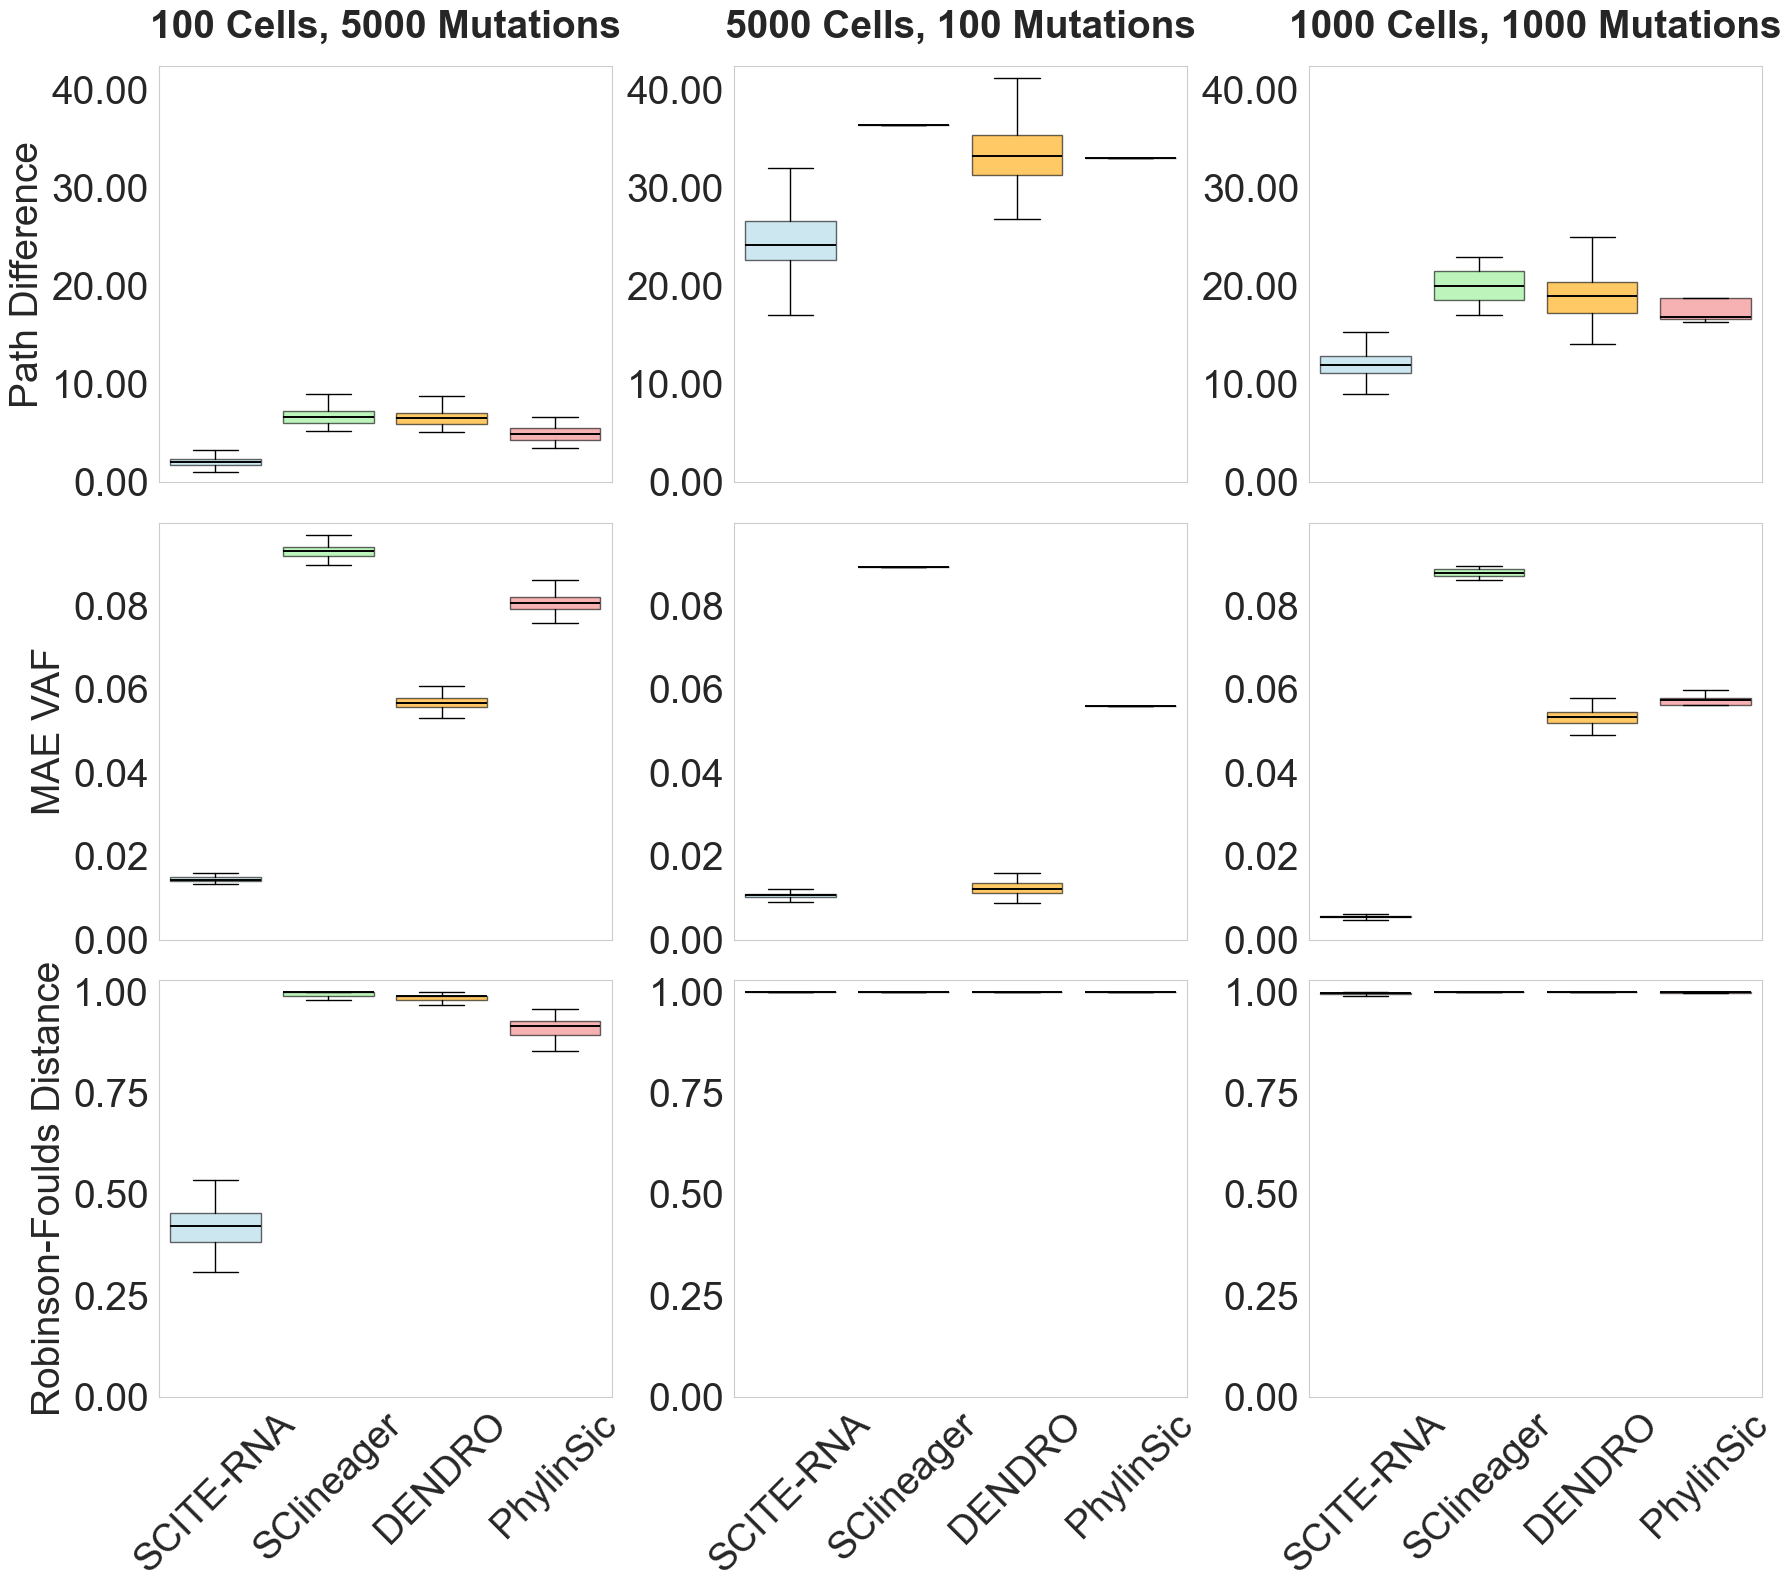

In [38]:
def plot_large_datasets(data_list, ncs, nms, models=["SCITE-RNA", "SClineager", "DENDRO", "PhylinSic"]):
    rows = len(data_list)
    cols = len(ncs)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows + 1), sharey=False)
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)

    colors = ["lightblue", "lightgreen", "orange", "lightcoral"]
    alpha_value = 0.6

    title_size = 28
    label_size = 28
    tick_size = 28
    box_width = 1.4
    boxplot_widths = 0.8

    plot_titles = ["Path Difference", "MAE VAF", "Robinson-Foulds Distance"]

    for row_idx, (data, plot_title) in enumerate(zip(data_list, plot_titles)):
        row_whiskers = []

        for col_idx, n_c in enumerate(ncs):
            n_m = nms[col_idx]
            sample_key = f"{n_c}_{n_m}"
            all_samples = []
            for model in models:
                if model in data and sample_key in data[model]:
                    samples = data[model][sample_key]
                    if plot_title == "Robinson-Foulds Distance":
                        max_value = 2 * (n_c - 3)
                        samples = np.array(samples) / max_value
                    all_samples.append(samples)
            # all_samples = [data[model][sample_key] for model in models]
            ax = axes[row_idx, col_idx]
            box = ax.boxplot(all_samples, patch_artist=True, widths=boxplot_widths, showfliers=False)

            for patch, color in zip(box['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(alpha_value)

            for line in box['medians']:
                line.set_linewidth(box_width)
                line.set_color("black")

            whisker_data = np.concatenate([line.get_ydata() for line in box['whiskers']])
            row_whiskers.append(whisker_data)

            if row_idx == 0:
                ax.set_title(f"{n_c} Cells, {n_m} Mutations", fontsize=title_size, pad=20, fontweight="bold")

            if row_idx == rows - 1:
                ax.set_xticklabels(models, fontsize=tick_size)
            else:
                ax.set_xticks([])

            if col_idx == 0:
                ax.set_ylabel(plot_title, fontsize=label_size)

            ax.tick_params(axis='x', labelsize=tick_size, rotation=45)
            ax.tick_params(axis='y', labelsize=tick_size)
            ax.grid(False)
            ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

        if row_whiskers:
            combined = np.concatenate(row_whiskers)
            finite = combined[np.isfinite(combined)]
            if finite.size:
                ymin, ymax = finite.min(), finite.max()
            else:
                ymin, ymax = 0.0, 1.0
        else:
            ymin, ymax = 0.0, 1.0

        ymin = 0
        ymax *= 1.03

        for col_idx in range(cols):
            axes[row_idx, col_idx].set_ylim(ymin, ymax)

    plt.tight_layout()
    # plt.savefig("../data/results/figures/Figure_large_datasets.pdf")
    plt.show()

plot_large_datasets([path_differences_large, vaf_differences_large, rf_differences_large], n_cells, n_mutations) # some lists are empty, because this model doesn't have the respective data

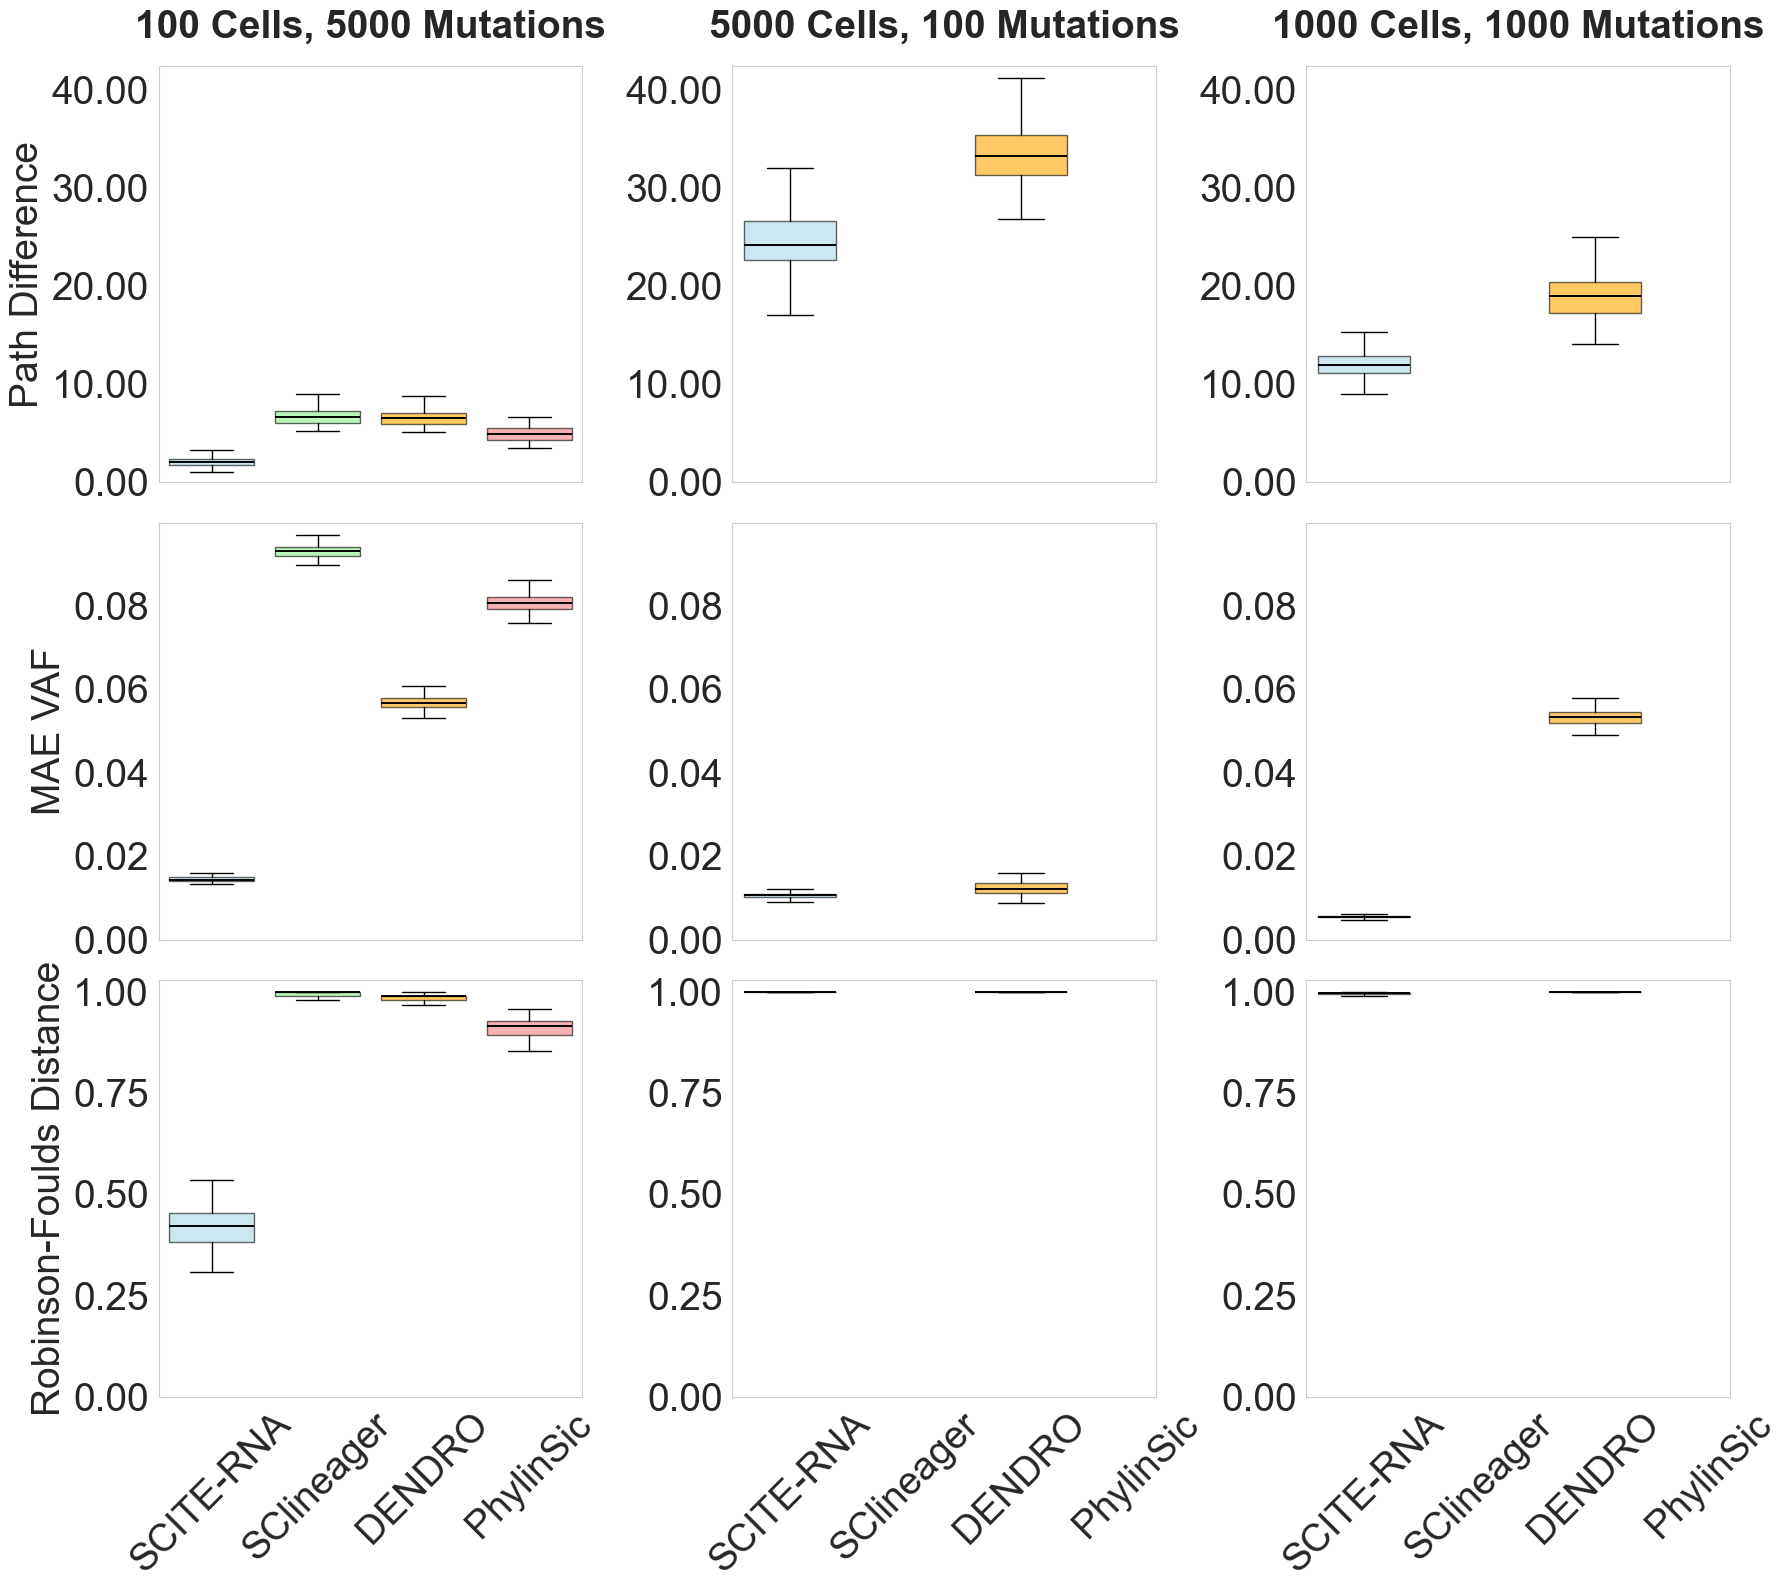

In [47]:
import matplotlib.ticker as mticker
import numpy as np
import matplotlib.pyplot as plt

def plot_large_datasets(data_list, ncs, nms, models=["SCITE-RNA", "SClineager", "DENDRO", "PhylinSic"]):
    rows = len(data_list)
    cols = len(ncs)
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows + 1), sharey=False)
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)
    colors = ["lightblue", "lightgreen", "orange", "lightcoral"]
    alpha_value = 0.6
    title_size = 28
    label_size = 28
    tick_size = 28
    box_width = 1.4
    boxplot_widths = 0.8
    plot_titles = ["Path Difference", "MAE VAF", "Robinson-Foulds Distance"]

    for row_idx, (data, plot_title) in enumerate(zip(data_list, plot_titles)):
        row_whiskers = []
        for col_idx, n_c in enumerate(ncs):
            n_m = nms[col_idx]
            sample_key = f"{n_c}_{n_m}"
            all_samples = []
            ax = axes[row_idx, col_idx]

            for model_idx, model in enumerate(models):
                if model in data and sample_key in data[model]:
                    samples = data[model][sample_key]
                    if plot_title == "Robinson-Foulds Distance":
                        max_value = 2 * (n_c - 3)
                        samples = np.array(samples) / max_value
                    all_samples.append(samples)

            # Plot boxplots or stars
            for model_idx, samples in enumerate(all_samples):
                if len(samples) < 10 and len(samples) > 0:
                    # Optionally plot a star for small sample sizes
                    y = np.mean(samples)
                    ax.plot(
                        model_idx + 1,
                        y,
                        marker="*",
                        markersize=12,
                        markeredgecolor=colors[model_idx],
                        markerfacecolor=colors[model_idx],
                        linestyle="",
                        zorder=10,
                        alpha=0.0,
                    )
                elif len(samples) >= 10:
                    # Plot a boxplot for larger sample sizes
                    box = ax.boxplot(
                        [samples],
                        positions=[model_idx + 1],
                        patch_artist=True,
                        widths=boxplot_widths,
                        showfliers=False,
                    )
                    for patch in box["boxes"]:
                        patch.set_facecolor(colors[model_idx])
                        patch.set_alpha(alpha_value)
                    for line in box["medians"]:
                        line.set_linewidth(box_width)
                        line.set_color("black")
                    whisker_data = np.concatenate([line.get_ydata() for line in box["whiskers"]])
                    row_whiskers.append(whisker_data)

            if row_idx == 0:
                ax.set_title(f"{n_c} Cells, {n_m} Mutations", fontsize=title_size, pad=20, fontweight="bold")
            if row_idx == rows - 1:
                ax.set_xticks(range(1, len(models) + 1))
                ax.set_xticklabels(models, fontsize=tick_size)
            else:
                ax.set_xticks([])
            if col_idx == 0:
                ax.set_ylabel(plot_title, fontsize=label_size)
            ax.tick_params(axis="x", labelsize=tick_size, rotation=45)
            ax.tick_params(axis="y", labelsize=tick_size)
            ax.grid(False)
            ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))

        if row_whiskers:
            combined = np.concatenate(row_whiskers)
            finite = combined[np.isfinite(combined)]
            if finite.size:
                ymin, ymax = finite.min(), finite.max()
            else:
                ymin, ymax = 0.0, 1.0
        else:
            ymin, ymax = 0.0, 1.0
        ymin = 0
        ymax *= 1.03
        for col_idx in range(cols):
            axes[row_idx, col_idx].set_ylim(ymin, ymax)

    plt.tight_layout()
    # plt.savefig("../data/results/figures/Figure_large_datasets.pdf")
    plt.show()

# Example usage:
plot_large_datasets([path_differences_large, vaf_differences_large, rf_differences_large], n_cells, n_mutations)

In [6]:
for i in range(13):
    print(i*1.1)

0.0
1.1
2.2
3.3000000000000003
4.4
5.5
6.6000000000000005
7.700000000000001
8.8
9.9
11.0
12.100000000000001
13.200000000000001


In [14]:
import numpy as np
np.array([int(i*11)/10 for i in range(35)])

array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ,
       12.1, 13.2, 14.3, 15.4, 16.5, 17.6, 18.7, 19.8, 20.9, 22. , 23.1,
       24.2, 25.3, 26.4, 27.5, 28.6, 29.7, 30.8, 31.9, 33. , 34.1, 35.2,
       36.3, 37.4])